In [3]:
import numpy as np
import matplotlib.pyplot as plt


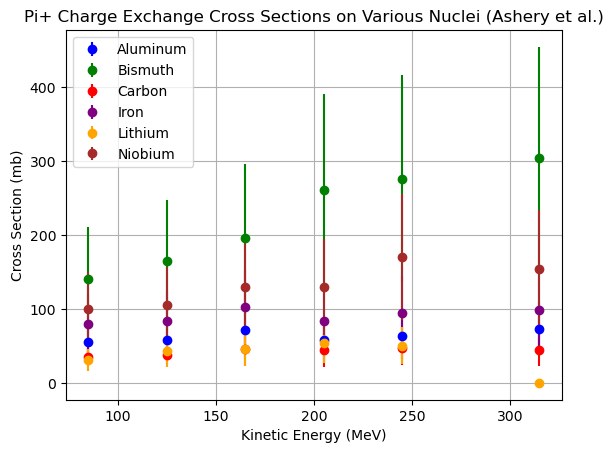

In [4]:
#Read in the data from subfolders
#pipA_cex
#Specifically the Ashery data on pi plus charge exchange on the following nuclei:
#Al, Bi, C, Fe, Li, Nb 

data_al = np.loadtxt('pipA_cex/ashery-pip-al-cex.dat', skiprows=1)
data_bi = np.loadtxt('pipA_cex/ashery-pip-bi-cex.dat', skiprows=1)
data_c = np.loadtxt('pipA_cex/ashery-pip-c-cex.dat', skiprows=1)
data_fe = np.loadtxt('pipA_cex/ashery-pip-fe-cex.dat', skiprows=1)
data_li = np.loadtxt('pipA_cex/ashery-pip-li-cex.dat', skiprows=1)
data_nb = np.loadtxt('pipA_cex/ashery-pip-nb-cex.dat', skiprows=1)

# Data are organized in 3 columns, separated by 5 spaces: KE in MeV, value of XS in mb, 1 sigma error in XS in mb
# Plot the data
plt.errorbar(data_al[:,0], data_al[:,1], yerr=data_al[:,2], fmt='o', label='Aluminum', color='blue')
plt.errorbar(data_bi[:,0], data_bi[:,1], yerr=data_bi[:,2], fmt='o', label='Bismuth', color='green')
plt.errorbar(data_c[:,0], data_c[:,1], yerr=data_c[:,2], fmt='o', label='Carbon', color='red')
plt.errorbar(data_fe[:,0], data_fe[:,1], yerr=data_fe[:,2], fmt='o', label='Iron', color='purple')
plt.errorbar(data_li[:,0], data_li[:,1], yerr=data_li[:,2], fmt='o', label  ='Lithium', color='orange')
plt.errorbar(data_nb[:,0], data_nb[:,1], yerr=data_nb[:,2], fmt='o', label='Niobium', color='brown')
plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Cross Section (mb)')
plt.title('Pi+ Charge Exchange Cross Sections on Various Nuclei (Ashery et al.)')
plt.legend()
plt.yscale('linear')
plt.grid(True)
plt.show()  

In [21]:
nuclei = {
    "H":  {"A": 1,  "Z": 1,  "N": 0},
    "He": {"A": 4,  "Z": 2,  "N": 2},
    "Li": {"A": 7,  "Z": 3,  "N": 4},
    "C":  {"A": 12, "Z": 6,  "N": 6},
    "Al": {"A": 27, "Z": 13, "N": 14},
    "Nb": {"A": 93, "Z": 41, "N": 52},
    "Bi": {"A": 209,"Z": 83, "N": 126},
    "O":  {"A": 16, "Z": 8,  "N": 8},
    "Ar": {"A": 40, "Z": 18, "N": 22},
    "Fe": {"A": 56, "Z": 26, "N": 30},
}

nuclei_list = ["Al", "Bi", "C", "Fe", "Li", "Nb"]

#Make a list of N values for the nuclei in nuclei_list
N_list = [nuclei[nuc]["N"] for nuc in nuclei_list]
print("N values for nuclei:", N_list)

#Make a special list of nuclei excluding Lithium for fitting purposes
nuclei_list_no_li = ["Al", "Bi", "C", "Fe", "Nb"]
N_list_no_li = [nuclei[nuc]["N"] for nuc in nuclei_list_no_li]
print("N values for nuclei excluding Lithium:", N_list_no_li)

N values for nuclei: [14, 126, 6, 30, 4, 52]
N values for nuclei excluding Lithium: [14, 126, 6, 30, 52]


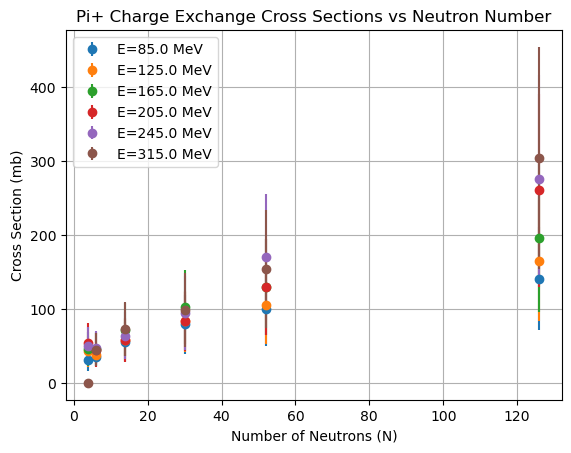

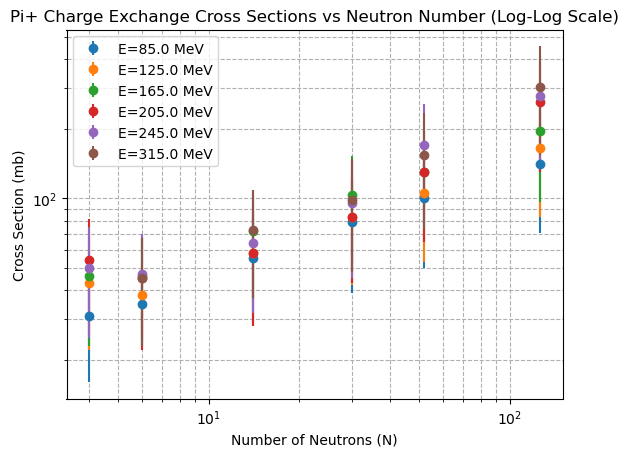

In [22]:
#Make a similar plot to the one above, except plot XS as a function of N, labeled by the kinetic energy.
#Don't use any new fit, just the data as given by visualized in this new way.
#Now plot xs with its error as a function of N
#Do not perform a fit here, just plot the data points with error bars
#Plot all energies on the same plot, with a legend indicating the kinetic energy
plt.figure()
for E in np.unique(data_al[:,0]):
    xs_values = []
    xs_errors = []
    N_values = []
    for nuc, data in zip(nuclei_list, [data_al, data_bi, data_c, data_fe, data_li, data_nb]):
        idx = np.where(data[:,0] == E)
        if len(idx[0]) > 0:
            xs = data[idx,1][0][0]
            xs_err = data[idx,2][0][0]
            xs_values.append(xs)
            xs_errors.append(xs_err)
            N = nuclei[nuc]["N"]
            N_values.append(N)
    plt.errorbar(N_values, xs_values, yerr=xs_errors, fmt='o', label=f'E={E} MeV')
plt.xlabel('Number of Neutrons (N)')
plt.ylabel('Cross Section (mb)')
plt.title('Pi+ Charge Exchange Cross Sections vs Neutron Number')
plt.legend()
plt.yscale('linear')
plt.grid(True)
plt.show()

## Recreate this as a log-log plot
plt.figure()
for E in np.unique(data_al[:,0]):
    xs_values = []
    xs_errors = []
    N_values = []
    for nuc, data in zip(nuclei_list, [data_al, data_bi, data_c, data_fe, data_li, data_nb]):
        idx = np.where(data[:,0] == E)
        if len(idx[0]) > 0:
            xs = data[idx,1][0][0]
            xs_err = data[idx,2][0][0]
            xs_values.append(xs)
            xs_errors.append(xs_err)
            N = nuclei[nuc]["N"]
            N_values.append(N)
    plt.errorbar(N_values, xs_values, yerr=xs_errors, fmt='o', label=f'E={E} MeV')
plt.xlabel('Number of Neutrons (N)')
plt.ylabel('Cross Section (mb)')
plt.title('Pi+ Charge Exchange Cross Sections vs Neutron Number (Log-Log Scale)')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()


In [38]:
#For each energy value, fit a power law to the data as a function of A and extract the exponent.
#Assign reasonable errors based on the provided error bars.
energies = np.unique(data_al[:,0])
exponents = []
exponent_errors = []
log_coefficients = []
log_coefficient_errors = []
exponent_log_coefficient_covariances = []
xs_estimated_values = []
xs_estimated_errors = []
log_xs_estimated_values = []
log_xs_estimated_errors = []
red_chi2_values = []

for E in energies:
    xs_values = []
    xs_errors = []
    N_values = []
    
    #exclude Lithium data from the fit because it looks weird
    for data, N in zip([data_al, data_bi, data_c, data_fe, data_nb], N_list_no_li):
        idx = np.where(data[:,0] == E)
        if idx[0].size > 0:
            xs_values.append(data[idx,1][0])
            xs_errors.append(data[idx,2][0])
            N_values.append(N)
    #Mask out any zero or negative XS values to avoid issues with log scale
    xs_values = np.asarray(xs_values).squeeze()
    xs_errors = np.asarray(xs_errors).squeeze()
    N_values = np.array(N_values)
    mask = xs_values > 0
    xs_values = xs_values[mask]
    xs_errors = xs_errors[mask]
    N_values = N_values[mask]

    

    if len(xs_values) >= 2:
        log_N = np.log(N_values)
        log_xs = np.log(xs_values)
        
        log_xs_errors = xs_errors / xs_values  # Propagate error to log space
        weights = 1 / np.array(log_xs_errors)**2
        
        #coeffs = np.polyfit(log_N, log_xs, 1, w=weights)
        #exponent = coeffs[0]

        #Analytical solution for weighted linear regression
        S = np.sum(weights)
        Sx = np.sum(weights * log_N)
        Sy = np.sum(weights * log_xs)
        Sxx = np.sum(weights * log_N**2)
        Sxy = np.sum(weights * log_N * log_xs)
        Delta = S * Sxx - Sx**2

        exponent = (S * Sxy - Sx * Sy) / Delta
        intercept = (Sxx * Sy - Sx * Sxy) / Delta

        # Residuals in log space
        Estimated_log_xs_values = intercept + exponent * log_N
        residuals = log_xs - Estimated_log_xs_values

        # Compute chi^2 and reduced chi^2
        chi2 = np.sum((residuals / log_xs_errors) ** 2)
        dof = max(1, len(log_N) - 2)  # avoid divide-by-zero if N==2
        chi2_red = chi2 / dof

        #Reduce chi2 value should be close to 1 for a good fit
        #Reduced chi2 values are all very low for this fit -- so the errors may be overestimated if the model is good
        #For now, keep reduced chi2 scaling to 1
        chi2_red = 1.0

        # Unscaled (theoretical) parameter covariance from WLS normal equations
        Var_exponent_unscaled = S / Delta
        Var_intercept_unscaled = Sxx / Delta
        Cov_exponent_intercept_unscaled = -Sx / Delta

        # ---- SCALE BY REDUCED CHI^2 ----
        # If measurement errors were underestimated (chi2_red > 1),
        # inflate the parameter covariance by chi2_red.
        Var_exponent  = chi2_red * Var_exponent_unscaled
        Var_intercept = chi2_red * Var_intercept_unscaled
        Cov_exponent_intercept = chi2_red * Cov_exponent_intercept_unscaled

        Var_estimated_log_xs = Var_intercept + 2*Cov_exponent_intercept * log_N + Var_exponent * log_N**2
        
        Estimated_xs_values = np.exp(Estimated_log_xs_values)
        Estimated_xs_errors = Estimated_xs_values * np.sqrt(Var_estimated_log_xs)

        exponents.append(exponent)
        exponent_errors.append(np.sqrt(Var_exponent))
        log_coefficients.append(intercept)
        log_coefficient_errors.append(np.sqrt(Var_intercept))
        exponent_log_coefficient_covariances.append(Cov_exponent_intercept)
        log_xs_estimated_values.append(Estimated_log_xs_values)
        log_xs_estimated_errors.append(np.sqrt(Var_estimated_log_xs))
        xs_estimated_values.append(Estimated_xs_values)
        xs_estimated_errors.append(Estimated_xs_errors)
        red_chi2_values.append(chi2_red)

In [24]:
#Print out everything:
#energies = np.unique(data_al[:,0])
#exponents = []
#exponent_errors = []
#log_coefficients = []
#log_coefficient_errors = []
#exponent_log_coefficient_covariances = []
#xs_estimated_values = []
#xs_estimated_errors = []
#log_xs_estimated_values = []
#log_xs_estimated_errors = []
#red_chi2_values = []

#Print the above values in a readable format
for i, E in enumerate(energies):
    print(f"E={E} MeV: Exponent = {exponents[i]:.4f} ± {exponent_errors[i]:.4f}, Log Coefficient = {log_coefficients[i]:.4f} ± {log_coefficient_errors[i]:.4f}, Covariance = {exponent_log_coefficient_covariances[i]:.4f}")

#Print out the red_chi2 values
for i, E in enumerate(energies):
    print(f"E={E} MeV: Reduced Chi^2 = {red_chi2_values[i]:.4f}")


E=85.0 MeV: Exponent = 0.4650 ± 0.1801, Log Coefficient = 2.7462 ± 0.5837, Covariance = -0.0986
E=125.0 MeV: Exponent = 0.4790 ± 0.1737, Log Coefficient = 2.7824 ± 0.5527, Covariance = -0.0898
E=165.0 MeV: Exponent = 0.4725 ± 0.2149, Log Coefficient = 3.0070 ± 0.7461, Covariance = -0.1530
E=205.0 MeV: Exponent = 0.5810 ± 0.2158, Log Coefficient = 2.6088 ± 0.7563, Covariance = -0.1559
E=245.0 MeV: Exponent = 0.6031 ± 0.2125, Log Coefficient = 2.6630 ± 0.7365, Covariance = -0.1490
E=315.0 MeV: Exponent = 0.6162 ± 0.2103, Log Coefficient = 2.6419 ± 0.7299, Covariance = -0.1461
E=85.0 MeV: Reduced Chi^2 = 1.0000
E=125.0 MeV: Reduced Chi^2 = 1.0000
E=165.0 MeV: Reduced Chi^2 = 1.0000
E=205.0 MeV: Reduced Chi^2 = 1.0000
E=245.0 MeV: Reduced Chi^2 = 1.0000
E=315.0 MeV: Reduced Chi^2 = 1.0000


In [25]:
#Create a function to calculate the the estimated XS given a value of N and kinetic energy KE
#Also return the error bars on the estimated XS
def estimate_log_xs(N, KE):
    if KE in energies:
        idx = np.where(energies == KE)[0][0]
        exponent = exponents[idx]
        log_coefficient = log_coefficients[idx]
        estimated_log_xs = log_coefficient + exponent * np.log(N)
        estimated_log_xs_error = np.sqrt(
            log_coefficient_errors[idx]**2 +
            (exponent_errors[idx] * np.log(N))**2 +
            2 * exponent_log_coefficient_covariances[idx] * np.log(N)
        )
        return estimated_log_xs , estimated_log_xs_error
    elif KE == 50.0:
        exponent = exponent_navon
        log_coefficient = log_coefficient_navon
        estimated_log_xs = log_coefficient + exponent * np.log(N)
        estimated_log_xs_error = np.sqrt(
            log_coefficient_error_navon**2 +
            (exponent_error_navon * np.log(N))**2 +
            2 * covariance_navon * np.log(N)
        )
        return estimated_log_xs , estimated_log_xs_error
    else:
        raise ValueError("Kinetic energy not found in the dataset.")

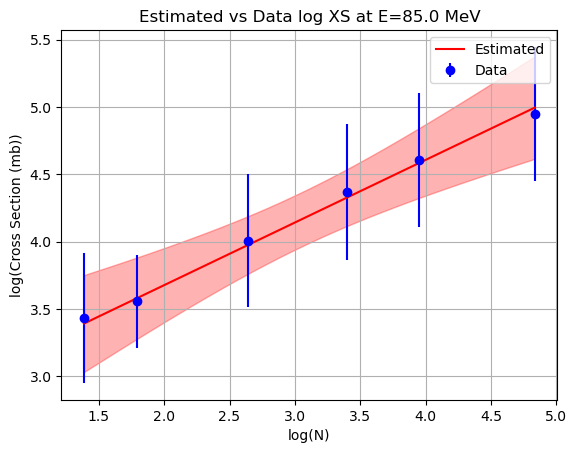

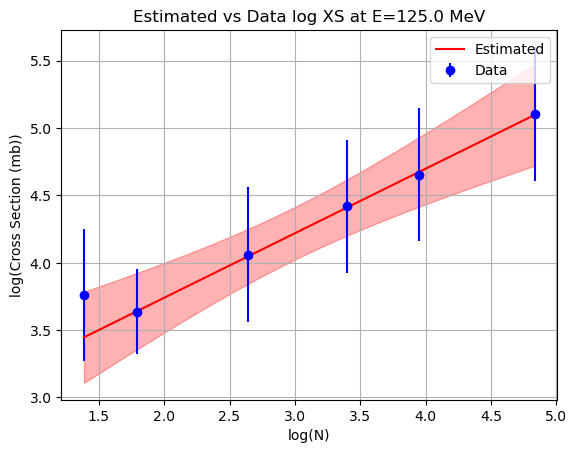

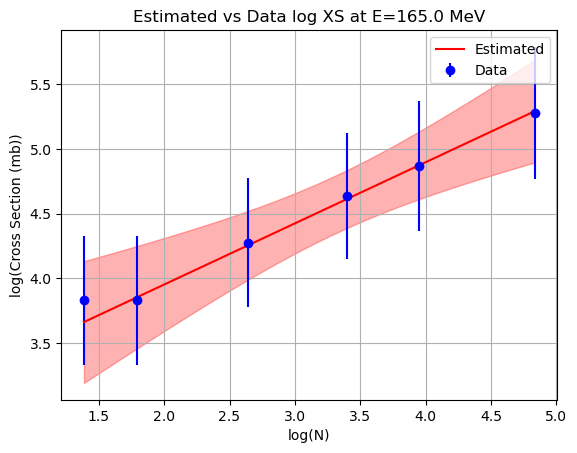

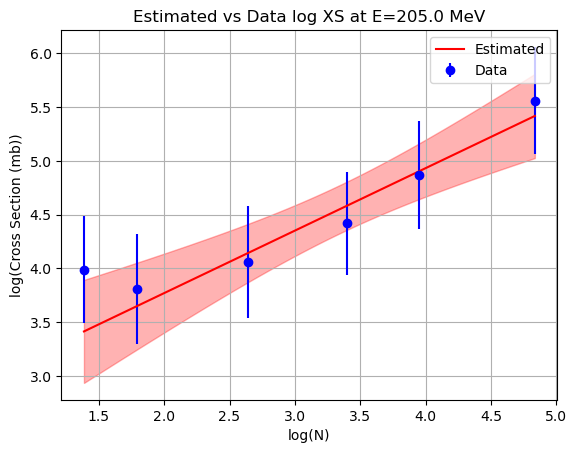

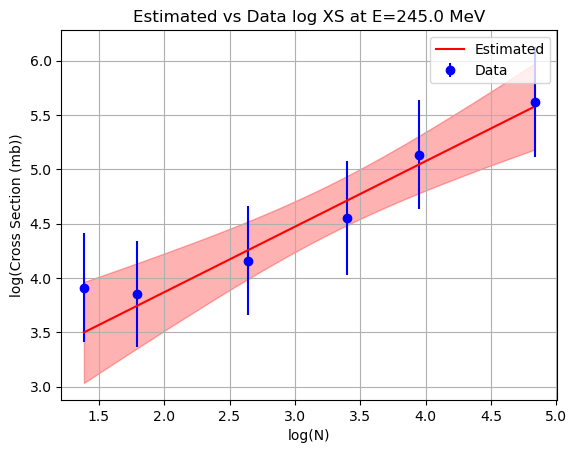

/tmp/ipykernel_5274/2483657264.py:25: RuntimeWarning: divide by zero encountered in log
  log_xs_values = np.log(xs_values)
/tmp/ipykernel_5274/2483657264.py:26: RuntimeWarning: invalid value encountered in divide
  log_xs_errors = xs_errors / xs_values  # Propagate error to log space


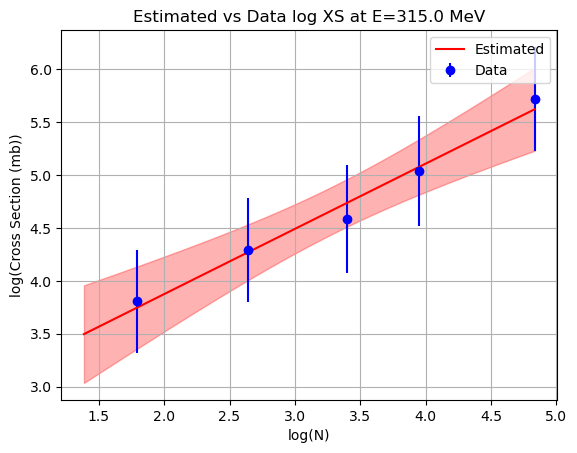

In [27]:
#For each energy, plot the estimated log XS as a function of N with error bars
#Include the data points as well with their error bars
#Make sure to propagate the errors from the data to log space correctly
#Make the visual in such a way that each energy gets its own subplot
#Also make sure the difference between estimated XS errors and data XS errors is clear
for E in energies:
    plt.figure()
    xs_values = []
    xs_errors = []
    N_values = []
    for nuc, data in zip(nuclei_list, [data_al, data_bi, data_c, data_fe, data_li, data_nb]):
        idx = np.where(data[:,0] == E)
        if len(idx[0]) > 0:
            xs = data[idx,1][0][0]
            xs_err = data[idx,2][0][0]
            xs_values.append(xs)
            xs_errors.append(xs_err)
            N = nuclei[nuc]["N"]
            N_values.append(N)
    N_values = np.array(N_values)
    xs_values = np.array(xs_values)
    xs_errors = np.array(xs_errors)
    
    log_N_values = np.log(N_values)
    log_xs_values = np.log(xs_values)
    log_xs_errors = xs_errors / xs_values  # Propagate error to log space

    plt.errorbar(log_N_values, log_xs_values, yerr=log_xs_errors, fmt='o', label='Data', color='blue')

    #Estimated values as a curve with shaded error band -- use many N values for smooth curve
    N_fit = np.linspace(min(N_values), max(N_values), 100)
    Estimated_log_xs_values, Estimated_log_xs_errors = estimate_log_xs(N_fit, E)
    plt.plot(np.log(N_fit), Estimated_log_xs_values, label='Estimated', color='red')
    plt.fill_between(np.log(N_fit), 
                     Estimated_log_xs_values - Estimated_log_xs_errors,
                     Estimated_log_xs_values + Estimated_log_xs_errors,
                     color='red', alpha=0.3)
    plt.xlabel('log(N)')
    plt.ylabel('log(Cross Section (mb))')
    plt.title(f'Estimated vs Data log XS at E={E} MeV')
    plt.legend()
    plt.grid(True)
    plt.show()

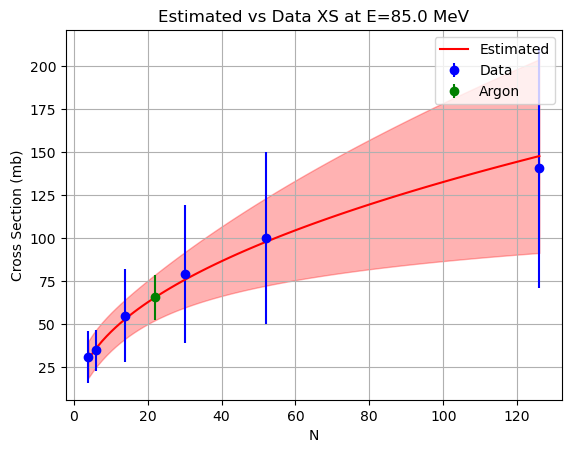

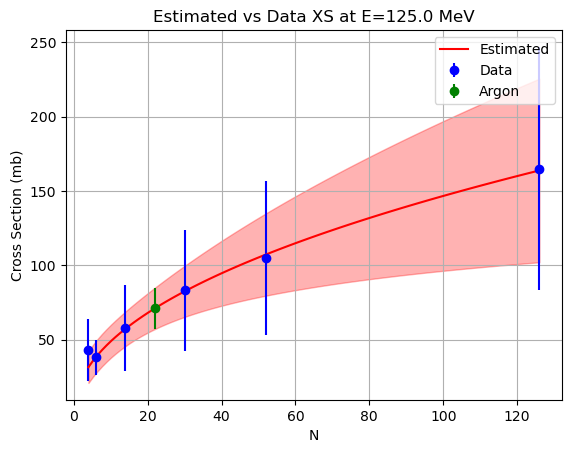

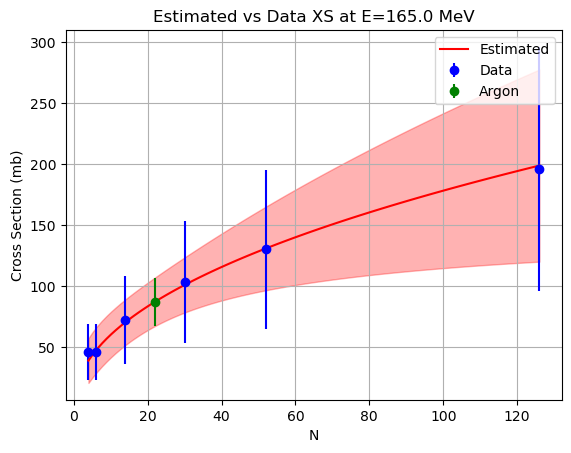

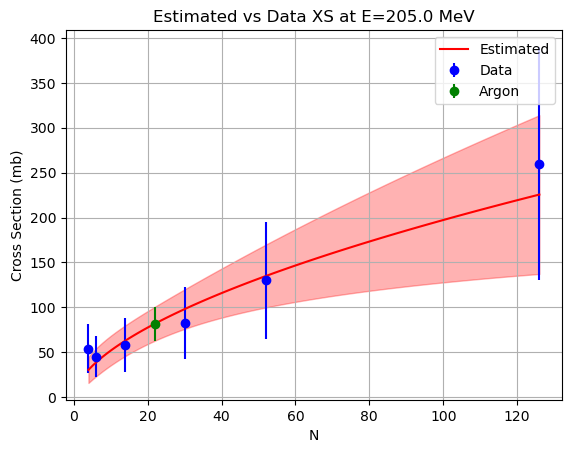

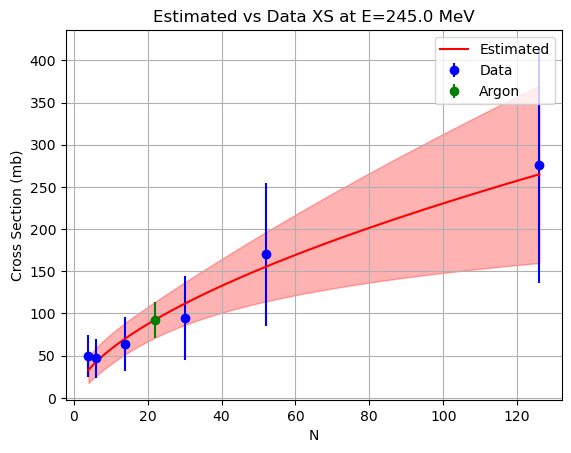

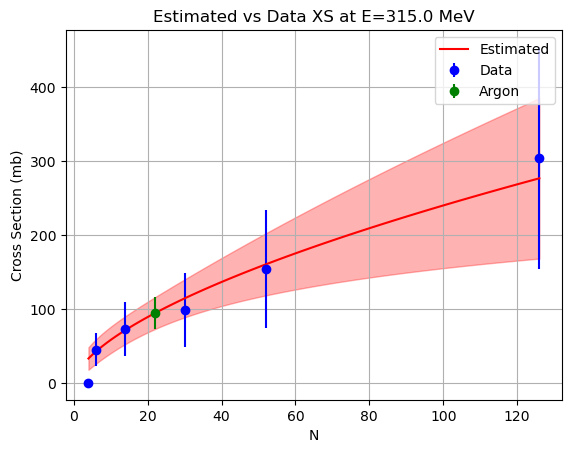

In [28]:
#Now plot the same thing, but port the estimation, error, and data back to linear scale
#Now plot the same thing, but port the estimation, error, and data back to linear scale
for E in energies:  
    plt.figure()
    xs_values = []
    xs_errors = []
    N_values = []
    for nuc, data in zip(nuclei_list, [data_al, data_bi, data_c, data_fe, data_li, data_nb]):
        idx = np.where(data[:,0] == E)
        if len(idx[0]) > 0:
            xs = data[idx,1][0][0]
            xs_err = data[idx,2][0][0]
            xs_values.append(xs)
            xs_errors.append(xs_err)
            N = nuclei[nuc]["N"]
            N_values.append(N)
    N_values = np.array(N_values)
    xs_values = np.array(xs_values)
    xs_errors = np.array(xs_errors)

    plt.errorbar(N_values, xs_values, yerr=xs_errors, fmt='o', label='Data', color='blue')

    Argon_xs_log, Argon_xs_log_err = estimate_log_xs(22, E)
    Argon_xs = np.exp(Argon_xs_log)
    Argon_xs_err = Argon_xs * Argon_xs_log_err
    plt.errorbar(22, Argon_xs, yerr=Argon_xs_err, fmt='o', label='Argon', color='green')

    #Estimated values as a curve with shaded error band -- use many N values for smooth curve
    N_fit = np.linspace(min(N_values), max(N_values), 100)
    Estimated_log_xs_values, Estimated_log_xs_errors = estimate_log_xs(N_fit, E)
    Estimated_xs_values = np.exp(Estimated_log_xs_values)
    Estimated_xs_errors = Estimated_xs_values * Estimated_log_xs_errors  # Propagate error back to linear space

    plt.plot(N_fit, Estimated_xs_values, label='Estimated', color='red')
    plt.fill_between(N_fit, 
                     Estimated_xs_values - Estimated_xs_errors,
                     Estimated_xs_values + Estimated_xs_errors,
                     color='red', alpha=0.3)
    plt.xlabel('N')
    plt.ylabel('Cross Section (mb)')
    plt.title(f'Estimated vs Data XS at E={E} MeV')
    plt.legend()
    plt.grid(True)
    plt.show()

E=85.0 MeV: Exponent = 0.4650 ± 0.1801, Log Coefficient = 2.7462 ± 0.5837, Covariance = -0.0986
E=125.0 MeV: Exponent = 0.4790 ± 0.1737, Log Coefficient = 2.7824 ± 0.5527, Covariance = -0.0898
E=165.0 MeV: Exponent = 0.4725 ± 0.2149, Log Coefficient = 3.0070 ± 0.7461, Covariance = -0.1530
E=205.0 MeV: Exponent = 0.5810 ± 0.2158, Log Coefficient = 2.6088 ± 0.7563, Covariance = -0.1559
E=245.0 MeV: Exponent = 0.6031 ± 0.2125, Log Coefficient = 2.6630 ± 0.7365, Covariance = -0.1490
E=315.0 MeV: Exponent = 0.6162 ± 0.2103, Log Coefficient = 2.6419 ± 0.7299, Covariance = -0.1461
E=85.0 MeV: Estimated XS for N=22 = 65.5916 ± 13.2331 mb
E=125.0 MeV: Estimated XS for N=22 = 71.0150 ± 13.9313 mb
E=165.0 MeV: Estimated XS for N=22 = 87.1362 ± 19.8819 mb
E=205.0 MeV: Estimated XS for N=22 = 81.8362 ± 18.9082 mb
E=245.0 MeV: Estimated XS for N=22 = 92.5004 ± 21.2556 mb
E=315.0 MeV: Estimated XS for N=22 = 94.3210 ± 21.5361 mb


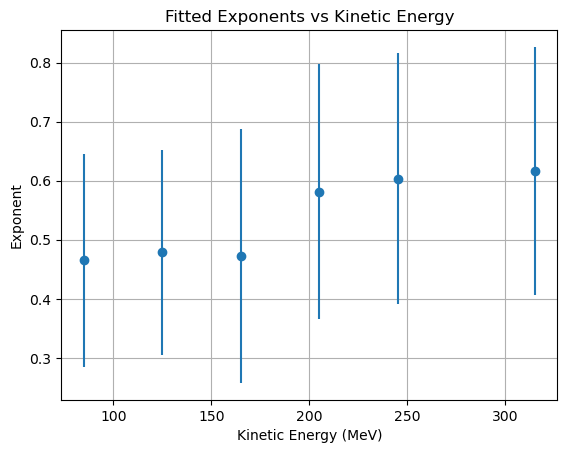

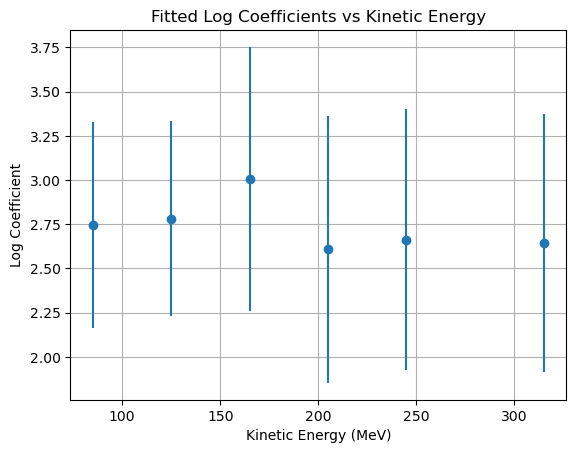

In [29]:
#Print out the list of exponents, log coefficients, and their errors and covariances
for i, E in enumerate(energies):
    print(f"E={E} MeV: Exponent = {exponents[i]:.4f} ± {exponent_errors[i]:.4f}, Log Coefficient = {log_coefficients[i]:.4f} ± {log_coefficient_errors[i]:.4f}, Covariance = {exponent_log_coefficient_covariances[i]:.4f}")

#Print out the estimated XS and error for N=22 (Argon) at each energy
for i, E in enumerate(energies):
    estimated_log_xs, estimated_log_xs_error = estimate_log_xs(22, E)
    estimated_xs = np.exp(estimated_log_xs)
    estimated_xs_error = estimated_xs * estimated_log_xs_error
    print(f"E={E} MeV: Estimated XS for N=22 = {estimated_xs:.4f} ± {estimated_xs_error:.4f} mb")

#Plot the exponents with error bars as a function of energy
plt.figure()
plt.errorbar(energies, exponents, yerr=exponent_errors, fmt='o')
plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Exponent')
plt.title('Fitted Exponents vs Kinetic Energy')
plt.grid(True)
plt.show()

#Plot the log coefficients with error bars as a function of energy
plt.figure()
plt.errorbar(energies, log_coefficients, yerr=log_coefficient_errors, fmt='o')
plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Log Coefficient')
plt.title('Fitted Log Coefficients vs Kinetic Energy')
plt.grid(True)
plt.show()

('pi+', '12C', 64, 10)
('pi+', '16O', 80, 12)
('pi+', 'Ni', 158, 20)
('pi+', 'Pb', 252, 30)
('pi-', '12C', 64, 10)
('pi-', '16O', 80, 12)
('pi-', '18O', 73, 15)
('pi-', '129Sn', 127, 25)
('pi-', 'Pb', 113, 16)
Probes: ['pi+' 'pi+' 'pi+' 'pi+' 'pi-' 'pi-' 'pi-' 'pi-' 'pi-']
Targets: ['12C' '16O' 'Ni' 'Pb' '12C' '16O' '18O' '129Sn' 'Pb']
XS values: [ 64  80 158 252  64  80  73 127 113]
Errors: [10 12 20 30 10 12 15 25 16]


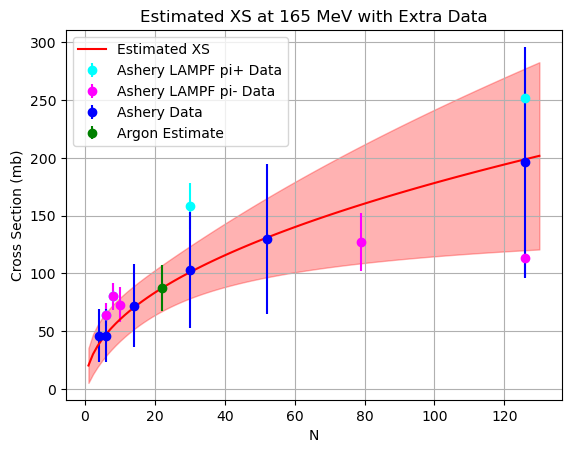

In [30]:
#Recreate the estimated XS plot for 165 MeV, including additional data from "ashery-pip-pim-A-cex_clean.dat"
#First read in the data from the file appropriately
# The data file is the following:
#Ashery (LAMPF) 160 MeV
# PRC 30, 946 (1984)
#probe       target       xs (mb)       error (mb)
#pi+       12C       64       10
#pi+       16O       80       12
#pi+       Ni       158       20
#pi+       Pb       252       30
#pi-       12C       64       10
#pi-       16O       80       12
#pi-       18O       73       15
#pi-       129Sn       127       25
#pi-       Pb       113       16

#There are exactly 7 spaces bewteen each column
data_cex_extra = np.genfromtxt('pipA_cex/ashery-pip-pim-A-cex_clean.dat', skip_header=3, dtype=None, encoding=None,
                              names=['probe', 'target', 'xs', 'error'], delimiter='       ')

#Print out rows and check they are read in correctly
for row in data_cex_extra:
    print(row)

#Print out each column separately to verify
print("Probes:", data_cex_extra['probe'])
print("Targets:", data_cex_extra['target'])
print("XS values:", data_cex_extra['xs'])
print("Errors:", data_cex_extra['error'])

#Map target nuclei to N values
target_to_N = {
    "12C": 6,
    "16O": 8,
    "Ni": 30,
    "Pb": 126,
    "18O": 10,
    "129Sn": 79,
}
#Extract data for 165 MeV pi+ CEX
E_target = 165
xs_values_extra = []
xs_errors_extra = []
N_values_extra = []
for row in data_cex_extra:
    probe = row['probe']
    target = row['target']
    xs = row['xs']
    xs_err = row['error']
    if probe == 'pi+' or probe == 'pi+/-':
        N = target_to_N[target]
        xs_values_extra.append(xs)
        xs_errors_extra.append(xs_err)
        N_values_extra.append(N)

#Extract data for 165 MeV pi- CEX
xs_values_extra_pim = []
xs_errors_extra_pim = []
N_values_extra_pim = []
for row in data_cex_extra:
    probe = row['probe']
    target = row['target']
    xs = row['xs']
    xs_err = row['error']
    if probe == 'pi-' or probe == 'pi+/-':
        N = target_to_N[target]
        xs_values_extra_pim.append(xs)
        xs_errors_extra_pim.append(xs_err)
        N_values_extra_pim.append(N)

#Now plot the estimated XS at 165 MeV along with the extra data points
plt.figure()
#Plot the extra data points first
plt.errorbar(N_values_extra, xs_values_extra, yerr=xs_errors_extra, fmt='o', label='Ashery LAMPF pi+ Data', color='cyan')
plt.errorbar(N_values_extra_pim, xs_values_extra_pim, yerr=xs_errors_extra_pim, fmt='o', label='Ashery LAMPF pi- Data', color='magenta')
#Plot the estimated XS curve
N_fit = np.linspace(1, 130, 100)
Estimated_log_xs_values, Estimated_log_xs_errors = estimate_log_xs(N_fit, 165)
Estimated_xs_values = np.exp(Estimated_log_xs_values)
Estimated_xs_errors = Estimated_xs_values * Estimated_log_xs_errors  # Propagate error back to linear space

#Plot the previous data at 165 MeV as well
xs_values_165 = []
xs_errors_165 = []
N_values_165 = []
for nuc, data in zip(nuclei_list, [data_al, data_bi, data_c, data_fe, data_li, data_nb]):
    idx = np.where(data[:,0] == 165)
    if len(idx[0]) > 0:
        xs = data[idx,1][0][0]
        xs_err = data[idx,2][0][0]
        xs_values_165.append(xs)
        xs_errors_165.append(xs_err)
        N = nuclei[nuc]["N"]
        N_values_165.append(N)
plt.errorbar(N_values_165, xs_values_165, yerr=xs_errors_165, fmt='o', label='Ashery Data', color='blue')

plt.plot(N_fit, Estimated_xs_values, label='Estimated XS', color='red')
plt.fill_between(N_fit, 
                 Estimated_xs_values - Estimated_xs_errors,
                 Estimated_xs_values + Estimated_xs_errors,
                 color='red', alpha=0.3)

#Also add in estimate for argon with error
Argon_xs_log, Argon_xs_log_err = estimate_log_xs(22, 165)
Argon_xs = np.exp(Argon_xs_log)
Argon_xs_err = Argon_xs * Argon_xs_log_err
plt.errorbar(22, Argon_xs, yerr=Argon_xs_err, fmt='o', label='Argon Estimate', color='green')

plt.xlabel('N')
plt.ylabel('Cross Section (mb)')
plt.title('Estimated XS at 165 MeV with Extra Data')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
#Now we that we have per-energy fits of XS vs N, we can do 2 things:
#Interpolation for energy
#Global fit
#And compare the two methods for estimating XS at N=22 (Argon) across the energy range.

######Interpolation for energy######

#First, create an interpolation function for exponent and log coefficient as a function of energy
#Also make sure to include a reasonable extrapolation below 85 MeV and above 315 MeV

### NO ###
#For below 85 MeV, use a smooth curve down to 0 at 0 MeV -- so we can add [0,0] as an extra point for interpolation

#Use a linear fit to esimate the exponent and errors at 0 MeV
#from scipy.stats import linregress
#slope, intercept, r_value, p_value, std_err = linregress(energies, exponents)
#exponent_0MeV = intercept
#exponent_error_0MeV = std_err

#energies_extended = np.concatenate(([0], energies))
#log_coefficients_extended = np.concatenate(([0], log_coefficients))
#exponents_extended = np.concatenate(([exponent_0MeV], exponents))
#exponent_errors_extended = np.concatenate(([exponent_errors[0]], exponent_errors))
#log_coefficient_errors_extended = np.concatenate(([log_coefficient_errors[0]], log_coefficient_errors))
#exponent_log_coefficient_covariances_extended = np.concatenate(([exponent_log_coefficient_covariances[0]], exponent_log_coefficient_covariances))

#energies_extended = energies
#log_coefficients_extended = log_coefficients
#exponents_extended = exponents
#exponent_errors_extended = exponent_errors
#log_coefficient_errors_extended = log_coefficient_errors
#exponent_log_coefficient_covariances_extended = exponent_log_coefficient_covariances

#extend the energies and fit parameters to 50 MeV using the Navon 50 MeV fit values
energies_extended = np.concatenate(([50], energies))
log_coefficients_extended = np.concatenate(([log_coefficient_navon], log_coefficients))
exponents_extended = np.concatenate(([exponent_navon], exponents))
exponent_errors_extended = np.concatenate(([exponent_error_navon], exponent_errors))
log_coefficient_errors_extended = np.concatenate(([log_coefficient_error_navon], log_coefficient_errors))
exponent_log_coefficient_covariances_extended = np.concatenate(([covariance_navon], exponent_log_coefficient_covariances))

print(energies_extended)
print(exponents_extended)
print(log_coefficients_extended)

from scipy.interpolate import interp1d
exponent_interp = interp1d(energies_extended, exponents_extended, kind='quadratic', fill_value='extrapolate')
log_coefficient_interp = interp1d(energies_extended, log_coefficients_extended, kind='quadratic', fill_value='extrapolate')

exponent_error_interp = interp1d(energies_extended, exponent_errors_extended, kind='quadratic', fill_value='extrapolate')
log_coefficient_error_interp = interp1d(energies_extended, log_coefficient_errors_extended, kind='quadratic', fill_value='extrapolate')
exponent_log_coefficient_covariance_interp = interp1d(energies_extended, exponent_log_coefficient_covariances_extended, kind='quadratic', fill_value='extrapolate')

#Define a function to estimate XS using interpolation
#Make sure to estimate the error bars as well using interpolation of errors
#The estimation of the error bars should take into account the covariance between exponent and log coefficient


def estimate_log_xs_interpolated(N, KE):
    exponent = exponent_interp(KE)
    log_coefficient = log_coefficient_interp(KE)
    estimated_log_xs = log_coefficient + exponent * np.log(N)
    
    exponent_err = exponent_error_interp(KE)
    log_coefficient_err = log_coefficient_error_interp(KE)
    covariance = exponent_log_coefficient_covariance_interp(KE)
    
    estimated_log_xs_error = np.sqrt(
        log_coefficient_err**2 +
        (exponent_err * np.log(N))**2 +
        2 * covariance * np.log(N)
    )

    #For below 85 MeV, use a smooth curve down to 0 at 0 MeV
    #Specifically, use a quadratic interpolation in the XS, not log, between 0 MeV (0 XS) and 85 MeV (value at 85 MeV)
    #Such that the value and derivative for the existing interpolation and this new extrapolation match at 85 MeV
    #For the XS, not the log XS
    if KE < min(energies_extended):
        #Get XS and derivative at 85 MeV
        KE_low = min(energies_extended)
        exponent_low = exponent_interp(KE_low)
        log_coefficient_low = log_coefficient_interp(KE_low)
        xs_low = np.exp(log_coefficient_low + exponent_low * np.log(N))
        
        #Derivative of log_xs with respect to KE
        #We can compute the derivative numerically
        delta_KE = 1e-3  # small step in MeV
        exponent_high = exponent_interp(KE_low + delta_KE)
        log_coefficient_high = log_coefficient_interp(KE_low + delta_KE)
        xs_high = np.exp(log_coefficient_high + exponent_high * np.log(N))
        dxs_dKE = (xs_high - xs_low) / delta_KE      
        
        #Quadratic coefficients: a*KE^2 + b*KE + c
        #c = 0 (at 0 MeV, XS=0)
        #At KE_low: a*KE_low^2 + b*KE_low = xs_low
        #Derivative at KE_low: 2*a*KE_low + b = dxs_dKE
        A = np.array([[KE_low**2, KE_low],
                      [2*KE_low, 1]])
        B = np.array([xs_low, dxs_dKE])
        a, b = np.linalg.solve(A, B)
        
        xs_extrapolated = a * KE**2 + b * KE
        estimated_log_xs = np.log(xs_extrapolated)
        
        #Estimate error as proportional to the ratio of extrapolated to low value
        estimated_log_xs_error = estimated_log_xs_error * (xs_extrapolated / xs_low)

    #For above 315 MeV, use a flat extrapolation from the value at 315 MeV
    if KE > max(energies):
        exponent = exponents[-1]
        log_coefficient = log_coefficients[-1]
        estimated_log_xs = log_coefficient + exponent * np.log(N)
        
        exponent_err = exponent_errors[-1]
        log_coefficient_err = log_coefficient_errors[-1]
        covariance = exponent_log_coefficient_covariances[-1]
        
        estimated_log_xs_error = np.sqrt(
            log_coefficient_err**2 +
            (exponent_err * np.log(N))**2 +
            2 * covariance * np.log(N)
        )

    return estimated_log_xs , estimated_log_xs_error

[ 50.  85. 125. 165. 205. 245. 315.]
[0.34352553 0.46495618 0.47896778 0.4724961  0.58100714 0.60310458
 0.61622678]
[2.29849096 2.74624866 2.78238178 3.00696652 2.60880206 2.66299091
 2.64192098]


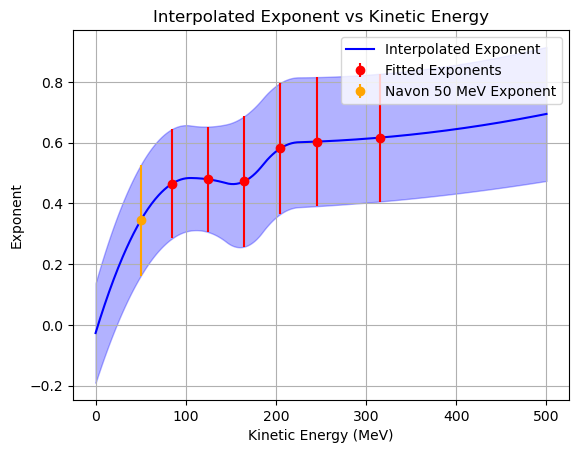

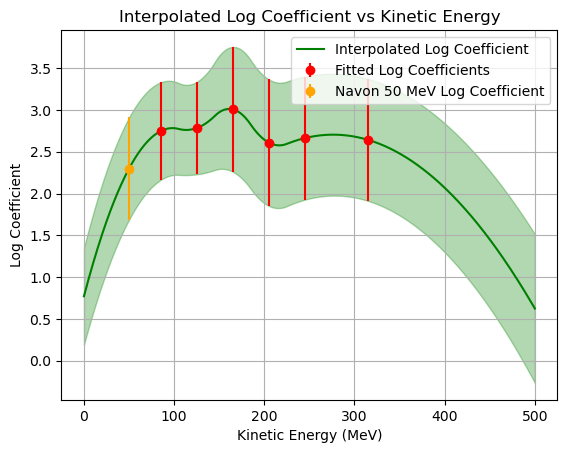

In [198]:
#Plot the interpolated and extrapolated values of the exponent with error bands
#Then plot the log coefficient with error bands

plt.figure()
KE_fit = np.linspace(0, 500, 500)
exponent_fit = exponent_interp(KE_fit)
exponent_err_fit = exponent_error_interp(KE_fit)
plt.plot(KE_fit, exponent_fit, label='Interpolated Exponent', color='blue')
plt.fill_between(KE_fit, 
                 exponent_fit - exponent_err_fit,
                 exponent_fit + exponent_err_fit,
                 color='blue', alpha=0.3)

#Overlay the fit value from each data energy as points with error bars
plt.errorbar(energies, exponents, yerr=exponent_errors, fmt='o', label='Fitted Exponents', color='red')
plt.errorbar(50, exponent_navon, yerr=exponent_error_navon, fmt='o', label='Navon 50 MeV Exponent', color='orange')
plt.legend()

plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Exponent')
plt.title('Interpolated Exponent vs Kinetic Energy')
plt.grid(True)
plt.show()

plt.figure()
log_coefficient_fit = log_coefficient_interp(KE_fit)
log_coefficient_err_fit = log_coefficient_error_interp(KE_fit)
plt.plot(KE_fit, log_coefficient_fit, label='Interpolated Log Coefficient', color='green')
plt.fill_between(KE_fit, 
                 log_coefficient_fit - log_coefficient_err_fit,
                 log_coefficient_fit + log_coefficient_err_fit,
                 color='green', alpha=0.3)

#Overlay the fit value from each data energy as points with error bars
plt.errorbar(energies, log_coefficients, yerr=log_coefficient_errors, fmt='o', label='Fitted Log Coefficients', color='red')
plt.errorbar(50, log_coefficient_navon, yerr=log_coefficient_error_navon, fmt='o', label='Navon 50 MeV Log Coefficient', color='orange')
plt.legend()    

plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Log Coefficient')
plt.title('Interpolated Log Coefficient vs Kinetic Energy')
plt.grid(True)
plt.show()

/tmp/ipykernel_5274/3254498310.py:103: RuntimeWarning: divide by zero encountered in log
  estimated_log_xs = np.log(xs_extrapolated)


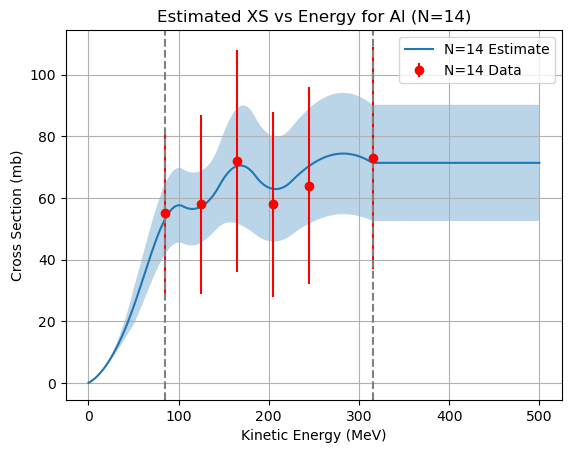

/tmp/ipykernel_5274/3254498310.py:103: RuntimeWarning: invalid value encountered in log
  estimated_log_xs = np.log(xs_extrapolated)


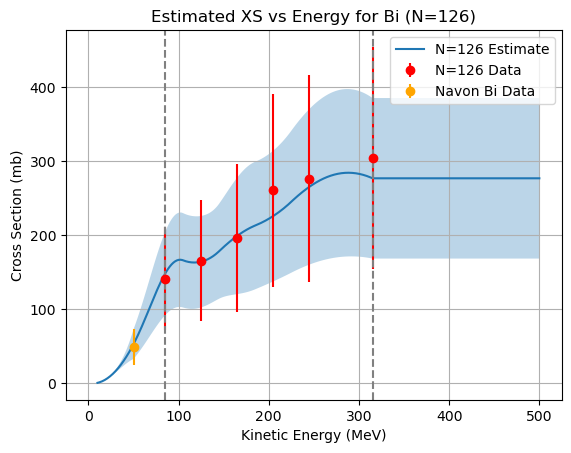

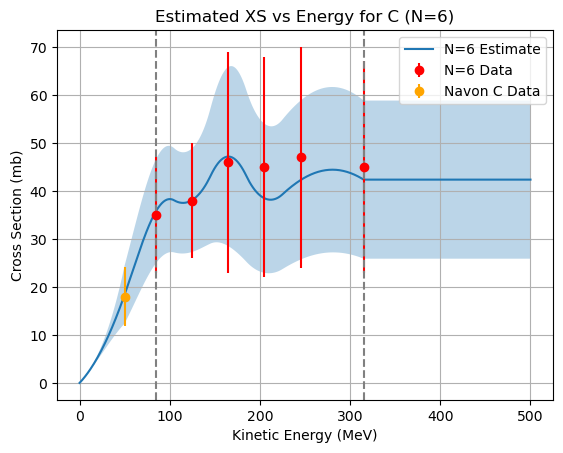

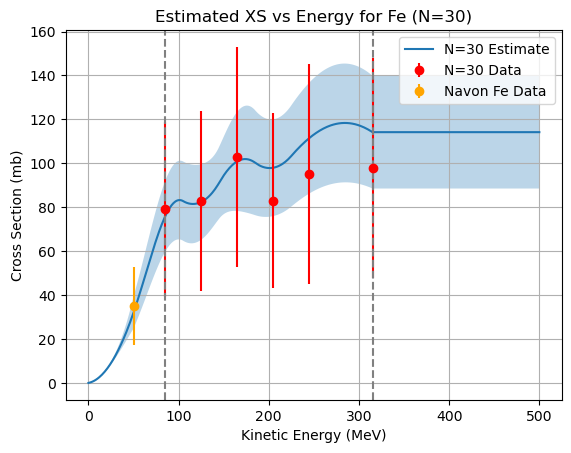

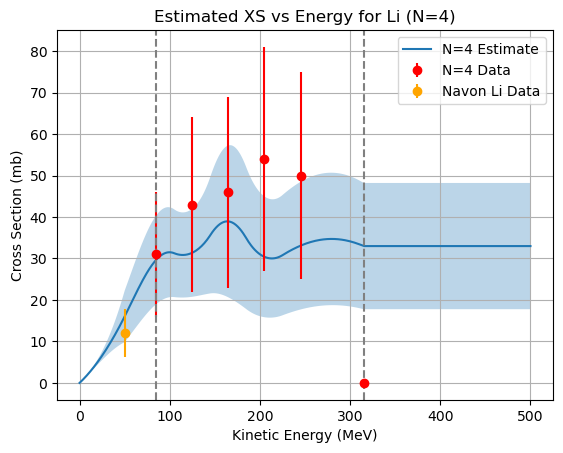

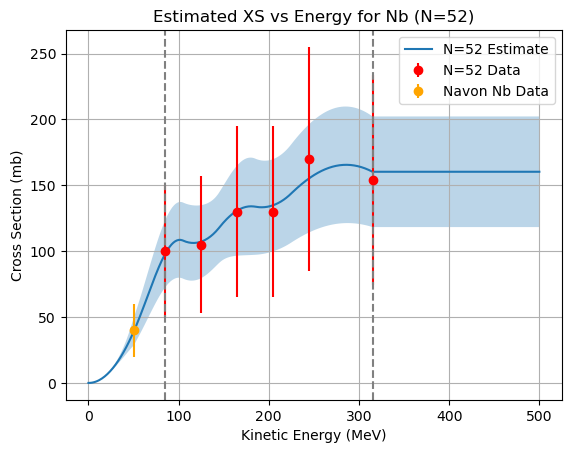

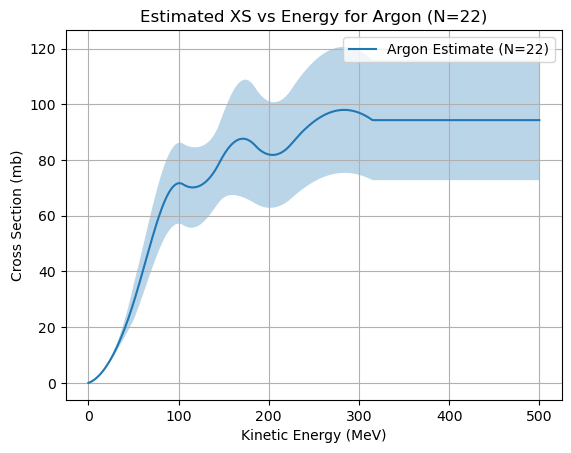

In [40]:
#For each nucleus (N value), plot the XS as a function of energy
#Plot the interpolated XS with error bands as well as the data points for each energy
N_values_to_plot = [14, 126, 6, 30, 4, 52]  # N values for Al, Bi, C, Fe, Li, Nb

energy_fit = np.linspace(0, 500, 500)
for N in N_values_to_plot:
    Estimated_log_xs_values = []
    Estimated_log_xs_errors = []
    for E in energy_fit:
        est_log_xs, est_log_xs_err = estimate_log_xs_interpolated(N, E)
        Estimated_log_xs_values.append(est_log_xs)
        Estimated_log_xs_errors.append(est_log_xs_err)
    Estimated_log_xs_values = np.array(Estimated_log_xs_values)
    Estimated_log_xs_errors = np.array(Estimated_log_xs_errors)
    Estimated_xs_values = np.exp(Estimated_log_xs_values)
    Estimated_xs_errors = Estimated_xs_values * Estimated_log_xs_errors  # Propagate error back to linear space

    plt.figure()
    plt.plot(energy_fit, Estimated_xs_values, label=f'N={N} Estimate')
    plt.fill_between(energy_fit, 
                     Estimated_xs_values - Estimated_xs_errors,
                     Estimated_xs_values + Estimated_xs_errors,
                     alpha=0.3)

    #Plot the data points for this N value
    xs_data = []
    xs_data_errors = []
    energy_data = []
    for i, E in enumerate(energies):
        data_nuclei = ["Al", "Bi", "C", "Fe", "Li", "Nb"]
        data_N_list = [nuclei[nuc]["N"] for nuc in data_nuclei]
        if N in data_N_list:
            idx = data_N_list.index(N)
            if idx < len([data_al, data_bi, data_c, data_fe, data_li, data_nb]):
                data = [data_al, data_bi, data_c, data_fe, data_li, data_nb][idx]
                data_idx = np.where(data[:,0] == E)
                if len(data_idx[0]) > 0:
                    xs_data.append(data[data_idx,1][0][0])
                    xs_data_errors.append(data[data_idx,2][0][0])
                    energy_data.append(E)
    plt.errorbar(energy_data, xs_data, yerr=xs_data_errors, fmt='o', label=f'N={N} Data', color='red')

    #If navon has this nucleus, plot that data point as well
    navon_nuclei = {"Bi": 126, "C": 6, "Fe": 30, "Li": 4, "Nb": 52}
    #print(data_navon)
    for nuc, N_navon in navon_nuclei.items():
        if N == N_navon:
            navon_data_idx = np.where(data_navon[:,0] == N)
            if len(navon_data_idx[0]) > 0:
                #print("here")
                xs_navon = data_navon[navon_data_idx,1][0][0]
                xs_navon_err = data_navon[navon_data_idx,2][0][0]
                plt.errorbar(50, xs_navon, yerr=xs_navon_err, fmt='o', label=f'Navon {nuc} Data', color='orange')

    #plot vertical lines at the minimum and maximum energy values of the data
    #So we can see where we are extrapolating
    plt.axvline(min(energies), color='gray', linestyle='--')
    plt.axvline(max(energies), color='gray', linestyle='--')
    plt.xlabel('Kinetic Energy (MeV)')
    plt.ylabel('Cross Section (mb)')
    #Title it with both N value and element symbol
    element_symbol = [key for key, value in nuclei.items() if value["N"] == N][0]
    plt.title(f'Estimated XS vs Energy for {element_symbol} (N={N})')
    plt.legend()
    plt.grid(True)
    plt.show()

#Make a plot of the estimated XS at N=22 (Argon) as a function of energy using the interpolation method
N_argon = 22
Estimated_log_xs_values = []
Estimated_log_xs_errors = []
for E in energy_fit:
    est_log_xs, est_log_xs_err = estimate_log_xs_interpolated(N_argon, E)
    Estimated_log_xs_values.append(est_log_xs)
    Estimated_log_xs_errors.append(est_log_xs_err)
Estimated_log_xs_values = np.array(Estimated_log_xs_values)
Estimated_log_xs_errors = np.array(Estimated_log_xs_errors)
Estimated_xs_values = np.exp(Estimated_log_xs_values)
Estimated_xs_errors = Estimated_xs_values * Estimated_log_xs_errors  # Propagate error back to linear space
plt.figure()
plt.plot(energy_fit, Estimated_xs_values, label='Argon Estimate (N=22)')
plt.fill_between(energy_fit, 
                 Estimated_xs_values - Estimated_xs_errors,
                 Estimated_xs_values + Estimated_xs_errors,
                 alpha=0.3)
plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Cross Section (mb)')
plt.title('Estimated XS vs Energy for Argon (N=22)')
plt.legend()
plt.grid(True)
plt.show()



In [32]:
#Plot the estimated XS at 50 MeV and include Navon data
#Navon data files are in pipA_cex/navon-pip-bi-cex.dat
#We have them for bi, fe, c, li, nb
#Data files all look like:
## KE	CEx
#50.0	35

#Read in Navon data -- separating it into KE and CEx columns
data_navon_bi = np.loadtxt('pipA_cex/navon-pip-bi-cex.dat', skiprows=1)
data_navon_fe = np.loadtxt('pipA_cex/navon-pip-fe-cex.dat', skiprows=1)
data_navon_c = np.loadtxt('pipA_cex/navon-pip-c-cex.dat', skiprows=1)
data_navon_li = np.loadtxt('pipA_cex/navon-pip-li-cex.dat', skiprows=1)
data_navon_nb = np.loadtxt('pipA_cex/navon-pip-nb-cex.dat', skiprows=1)

#If there is only one row, make sure it is 2D
if data_navon_bi.ndim == 1:
    data_navon_bi = data_navon_bi[np.newaxis, :]
if data_navon_fe.ndim == 1:
    data_navon_fe = data_navon_fe[np.newaxis, :]
if data_navon_c.ndim == 1:
    data_navon_c = data_navon_c[np.newaxis, :]
if data_navon_li.ndim == 1:
    data_navon_li = data_navon_li[np.newaxis, :]
if data_navon_nb.ndim == 1:
    data_navon_nb = data_navon_nb[np.newaxis, :]

#Extract 50 MeV data
xs_values_navon = []
N_values_navon = []
for nuc, data in zip(['Bi', 'Fe', 'C', 'Li', 'Nb'], 
                     [data_navon_bi, data_navon_fe, data_navon_c, data_navon_li, data_navon_nb]):
    idx = np.where(data[:,0] == 50.0)
    if len(idx[0]) > 0:
        xs = data[idx,1][0][0]
        xs_values_navon.append(xs)
        N = nuclei[nuc]["N"]
        N_values_navon.append(N)


In [34]:
#The above plot indicates that we should include Navon data in the fitting procedure for better accuracy at low energies.
#The Navon data points are generally lower than our estimates at 50 MeV.
#The Navon data points do not provide error bars, so we will have to assign reasonable errors to them.
#We can assign the same %error as the closest Ashery data point at 85 MeV for each nucleus.

#First, get the %error from Ashery data at 85 MeV for each nucleus
ashery_percent_errors = {}
for nuc, data in zip(['Bi', 'Fe', 'C', 'Li', 'Nb'], 
                     [data_bi, data_fe, data_c, data_li, data_nb]):
    idx = np.where(data[:,0] == 85.0)
    print(idx)
    print(idx[0][0])
    if len(idx[0]) > 0:
        xs = data[idx,1][0][0]
        xs_err = data[idx,2][0][0]
        print(xs)
        print(xs_err)
        percent_error = xs_err / xs
        ashery_percent_errors[nuc] = percent_error

print(ashery_percent_errors)

#Now assign errors to Navon data based on Ashery %errors
xs_errors_navon = []
for nuc, xs in zip(['Bi', 'Fe', 'C', 'Li', 'Nb'], xs_values_navon):
    percent_error = ashery_percent_errors.get(nuc, 0.3)  # default to 30% if not found
    print(percent_error)
    print(xs)
    xs_err = xs * percent_error
    xs_errors_navon.append(xs_err)

print(xs_errors_navon)


#Create a combined Navon data array for convenience, including errors
data_navon = np.array(list(zip(N_values_navon, xs_values_navon, xs_errors_navon)))

(array([0]),)
0
141.0
70.0
(array([0]),)
0
79.0
40.0
(array([0]),)
0
35.0
12.0
(array([0]),)
0
31.0
15.0
(array([0]),)
0
100.0
50.0
{'Bi': 0.49645390070921985, 'Fe': 0.5063291139240507, 'C': 0.34285714285714286, 'Li': 0.4838709677419355, 'Nb': 0.5}
0.49645390070921985
49.0
0.5063291139240507
35.0
0.34285714285714286
18.0
0.4838709677419355
12.0
0.5
40.0
[24.326241134751772, 17.721518987341774, 6.171428571428572, 5.806451612903226, 20.0]


In [ ]:
#Now plot estimated XS at 50 MeV with Navon data
plt.figure()
#Plot Navon data points -- they do not have error bars, do not assume any error bars
plt.errorbar(N_values_navon, xs_values_navon, fmt='o', label='Navon Data', color='orange')
#Plot estimated XS curve
N_fit = np.linspace(1, 130, 100)
Estimated_log_xs_values, Estimated_log_xs_errors = estimate_log_xs_interpolated(N_fit, 50)
Estimated_xs_values = np.exp(Estimated_log_xs_values)
Estimated_xs_errors = Estimated_xs_values * Estimated_log_xs_errors  # Propagate

plt.plot(N_fit, Estimated_xs_values, label='Estimated XS', color='red')
plt.fill_between(N_fit, 
                 Estimated_xs_values - Estimated_xs_errors,
                 Estimated_xs_values + Estimated_xs_errors,
                 color='red', alpha=0.3)
plt.xlabel('N')
plt.ylabel('Cross Section (mb)')
plt.title('Estimated XS at 50 MeV with Navon Data')
plt.legend()
plt.grid(True)
plt.show()

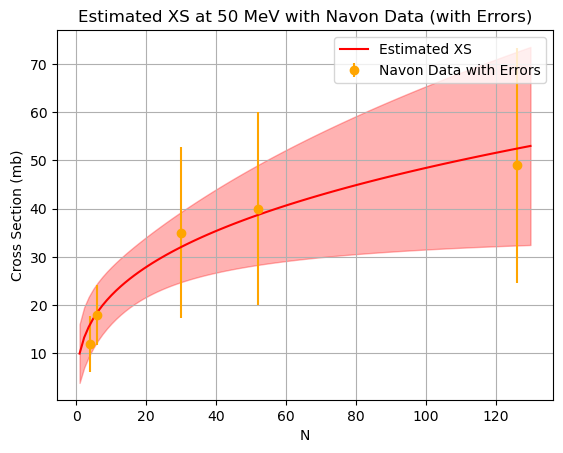

In [210]:
#Now plot estimated XS at 50 MeV with Navon data including error bars
plt.figure()
#Plot Navon data points with assigned error bars
plt.errorbar(N_values_navon, xs_values_navon, yerr=xs_errors_navon, fmt='o', label='Navon Data with Errors', color='orange')
#Plot estimated XS curve
N_fit = np.linspace(1, 130, 100)
Estimated_log_xs_values, Estimated_log_xs_errors = estimate_log_xs_interpolated(N_fit, 50)
Estimated_xs_values = np.exp(Estimated_log_xs_values)
Estimated_xs_errors = Estimated_xs_values * Estimated_log_xs_errors  # Propagate
plt.plot(N_fit, Estimated_xs_values, label='Estimated XS', color='red')
plt.fill_between(N_fit, 
                 Estimated_xs_values - Estimated_xs_errors,
                 Estimated_xs_values + Estimated_xs_errors,
                 color='red', alpha=0.3)
plt.xlabel('N')
plt.ylabel('Cross Section (mb)')
plt.title('Estimated XS at 50 MeV with Navon Data (with Errors)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Now do the per-energy fit for the 50 MeV Navon data
E = 50.0

#Exclude lithium for this fit
#Lithium is the 4th entry in the array -- set xs_values, xs_errors, N_values accordingly

xs_values_navon_excl_li = []
xs_errors_navon_excl_li = []
N_values_navon_excl_li = []
for i, nuc in enumerate(['Bi', 'Fe', 'C', 'Li', 'Nb']):
    if nuc != 'Li':
        xs_values_navon_excl_li.append(xs_values_navon[i])
        xs_errors_navon_excl_li.append(xs_errors_navon[i])
        N_values_navon_excl_li.append(N_values_navon[i])  

xs_values = np.array(xs_values_navon_excl_li)
xs_errors = np.array(xs_errors_navon_excl_li)
N_values = np.array(N_values_navon_excl_li)

log_N = np.log(N_values)
log_xs = np.log(xs_values)

log_xs_errors = xs_errors / xs_values  # Propagate error to log space
weights = 1 / np.array(log_xs_errors)**2

#coeffs = np.polyfit(log_N, log_xs, 1, w=weights)
#exponent = coeffs[0]

#Analytical solution for weighted linear regression
S = np.sum(weights)
Sx = np.sum(weights * log_N)
Sy = np.sum(weights * log_xs)
Sxx = np.sum(weights * log_N**2)
Sxy = np.sum(weights * log_N * log_xs)
Delta = S * Sxx - Sx**2

exponent = (S * Sxy - Sx * Sy) / Delta
intercept = (Sxx * Sy - Sx * Sxy) / Delta

# Residuals in log space
Estimated_log_xs_values = intercept + exponent * log_N
residuals = log_xs - Estimated_log_xs_values

# Compute chi^2 and reduced chi^2
chi2 = np.sum((residuals / log_xs_errors) ** 2)
dof = max(1, len(log_N) - 2)  # avoid divide-by-zero if N==2
chi2_red = chi2 / dof

#Reduce chi2 value should be close to 1 for a good fit
#Reduced chi2 values are all very low for this fit -- so the errors may be overestimated if the model is good
#For now, keep reduced chi2 scaling to 1
chi2_red = 1.0

# Unscaled (theoretical) parameter covariance from WLS normal equations
Var_exponent_unscaled = S / Delta
Var_intercept_unscaled = Sxx / Delta
Cov_exponent_intercept_unscaled = -Sx / Delta

# ---- SCALE BY REDUCED CHI^2 ----
# If measurement errors were underestimated (chi2_red > 1),
# inflate the parameter covariance by chi2_red.
Var_exponent  = chi2_red * Var_exponent_unscaled
Var_intercept = chi2_red * Var_intercept_unscaled
Cov_exponent_intercept = chi2_red * Cov_exponent_intercept_unscaled

Var_estimated_log_xs = Var_intercept + 2*Cov_exponent_intercept * log_N + Var_exponent * log_N**2

Estimated_xs_values = np.exp(Estimated_log_xs_values)
Estimated_xs_errors = Estimated_xs_values * np.sqrt(Var_estimated_log_xs)

#exponents.append(exponent)
#exponent_errors.append(np.sqrt(Var_exponent))
#log_coefficients.append(intercept)
#log_coefficient_errors.append(np.sqrt(Var_intercept))
#exponent_log_coefficient_covariances.append(Cov_exponent_intercept)
#log_xs_estimated_values.append(Estimated_log_xs_values)
#log_xs_estimated_errors.append(np.sqrt(Var_estimated_log_xs))
#xs_estimated_values.append(Estimated_xs_values)
#xs_estimated_errors.append(Estimated_xs_errors)
#red_chi2_values.append(chi2_red)

exponent_navon = exponent
exponent_error_navon = np.sqrt(Var_exponent)
log_coefficient_navon = intercept
log_coefficient_error_navon = np.sqrt(Var_intercept)
covariance_navon = Cov_exponent_intercept

[126  30   6   4  52]


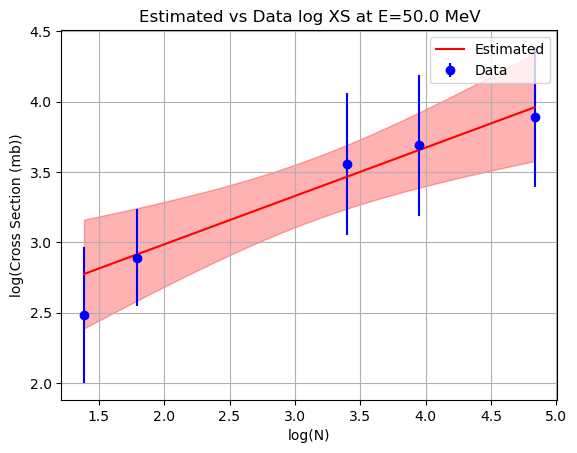

In [36]:
E = 50.    
plt.figure()

N_values = np.array(N_values_navon)
print(N_values)
log_N_values = np.log(N_values_navon)
log_xs_values = np.log(xs_values_navon)
log_xs_errors = np.array(xs_errors_navon) / np.array(xs_values_navon)  # Propagate error to log space

plt.errorbar(log_N_values, log_xs_values, yerr=log_xs_errors, fmt='o', label='Data', color='blue')

#Estimated values as a curve with shaded error band -- use many N values for smooth curve
N_fit = np.linspace(min(N_values), max(N_values), 100)
Estimated_log_xs_values, Estimated_log_xs_errors = estimate_log_xs(N_fit, E)
plt.plot(np.log(N_fit), Estimated_log_xs_values, label='Estimated', color='red')
plt.fill_between(np.log(N_fit), 
                    Estimated_log_xs_values - Estimated_log_xs_errors,
                    Estimated_log_xs_values + Estimated_log_xs_errors,
                    color='red', alpha=0.3)
plt.xlabel('log(N)')
plt.ylabel('log(Cross Section (mb))')
plt.title(f'Estimated vs Data log XS at E={E} MeV')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#The interpolation between energies produces unphysical wiggles in the estimated XS vs N at certain energies.
#To overcome this, instead of interpolating 1D power law fits at each energy, we can do a global 2D fit of XS vs N and E.
#We can use a function of the form:

# log(XS) = A_1 + A_2*log(N) + A_3*log(E) + A_4*log(E)^2 + A_5*log(E)^3 + A_6*log(N)*log(E)

#This captures the power law dependence on both N and E in log space.
#We can fit this function to all the data points across all energies simultaneously.

import numpy as np

def design_row(N, T, T0=200.0, degree=3, use_interaction=True):
    t = np.log(T / T0)
    feats = [1.0, np.log(N)]               # beta0, beta1
    # polynomial in t for energy shape (gamma_0..gamma_degree)
    feats += [t**(j+1) for j in range(degree)]
    if use_interaction:
        feats += [np.log(N) * t]           # eta
    return np.array(feats, dtype=float)

def global_logfit(N_arr, T_arr, sigma_arr, dsigma_arr, T0=200.0, degree=3, use_interaction=True):
    # Build X, y, W
    X = np.vstack([design_row(N, T, T0, degree, use_interaction) for N, T in zip(N_arr, T_arr)])
    y = np.log(sigma_arr)
    s = dsigma_arr / sigma_arr             # log-space errors
    W = np.diag(1.0 / (s**2))

    # Solve weighted normal equations
    XtW = X.T @ W
    H = XtW @ X                             # Hessian
    print(H)
    H_inv = np.linalg.inv(H)
    theta_hat = H_inv @ (XtW @ y)

    # Residuals and reduced chi^2
    yhat = X @ theta_hat
    chi2 = np.sum(((y - yhat) / s)**2)
    dof = max(1, len(y) - len(theta_hat))
    chi2_red = chi2 / dof
    print(f"Global fit reduced chi^2: {chi2_red}")

    # Parameter covariance scaled by chi2_red
    #Cov = chi2_red * H_inv
    Cov = H_inv # assume errors are accurate
    return theta_hat, Cov, chi2_red

def predict_sigma(N, T, theta_hat, Cov, T0=200.0, degree=3, use_interaction=True, tau2=0.0):
    x = design_row(N, T, T0, degree, use_interaction)
    mu = float(x @ theta_hat)
    V_mean = float(x @ Cov @ x)
    V = V_mean + float(tau2)               # add intrinsic scatter for prediction intervals
    median = np.exp(mu)
    factor68 = np.exp(np.sqrt(V))          # report as ×[1/factor68, factor68]
    mean = np.exp(mu + 0.5*V)
    return {"median": median, "mean": mean, "logvar": V, "factor68": factor68}


In [ ]:
nuclei = {
    "H":  {"A": 1,  "Z": 1,  "N": 0},
    "He": {"A": 4,  "Z": 2,  "N": 2},
    "Li": {"A": 7,  "Z": 3,  "N": 4},
    "C":  {"A": 12, "Z": 6,  "N": 6},
    "Al": {"A": 27, "Z": 13, "N": 14},
    "Nb": {"A": 93, "Z": 41, "N": 52},
    "Bi": {"A": 209,"Z": 83, "N": 126},
    "O":  {"A": 16, "Z": 8,  "N": 8},
    "Ar": {"A": 40, "Z": 18, "N": 22},
    "Fe": {"A": 56, "Z": 26, "N": 30},
}


In [161]:
degree = 3  # polynomial degree in log(E)
T0 = 200.0  # reference energy in MeV

In [160]:
#Take all of the Ashery data and combine into single arrays for N, T, XS, and XS errors
N_all = []
T_all = []
xs_all = []
xs_err_all = []

data_list = [data_al, data_bi, data_c, data_fe, data_nb] #Exclude lithium for this fit
nuclei_list_no_li = ['Al', 'Bi', 'C', 'Fe', 'Nb']
energies = data_al[:,0]  # all data files have the same energies
for i, E in enumerate(energies):
    for nuc, data in zip(nuclei_list_no_li, data_list):
        idx = np.where(data[:,0] == E)
        if len(idx[0]) > 0:
            xs = data[idx,1][0][0]
            xs_err = data[idx,2][0][0]
            N = nuclei[nuc]["N"]
            N_all.append(N)
            T_all.append(E)
            xs_all.append(xs)
            xs_err_all.append(xs_err)

#Also add in Navon data
#Assign errors as before -- fractional uncertainty = Ashery %error at 85 MeV for each nucleus
for nuc, data in zip(['Bi', 'Fe', 'C', 'Nb'], 
                     [data_navon_bi, data_navon_fe, data_navon_c, data_navon_nb]):
    idx = np.where(data[:,0] == 50.0)
    if len(idx[0]) > 0:
        xs = data[idx,1][0][0]
        percent_error = ashery_percent_errors.get(nuc, 0.3)  # default to 30% if not found
        xs_err = xs * percent_error
        N = nuclei[nuc]["N"]
        N_all.append(N)
        T_all.append(50.0)
        xs_all.append(xs)
        xs_err_all.append(xs_err)

##Add in Jones data for 400 and 500 MeV
#Jones data is stored in 5 files, one for each target: C, Ni, Zr, Sn, Pb
#Files are named jones-pip-<element>-cex.dat
jones_nuclei = {
    "C": 6,
    "Ni": 30,
    "Zr": 52,
    "Sn": 70,
    "Pb": 126
}
for nuc, N in jones_nuclei.items():
    data_jones = np.loadtxt(f'pipA_cex/jones-pip-{nuc.lower()}-cex.dat', skiprows=4)
    #If there is only one row, make sure it is 2D
    if data_jones.ndim == 1:
        data_jones = data_jones[np.newaxis, :]
    for E in [400.0, 500.0]:
        idx = np.where(data_jones[:,0] == E)
        if len(idx[0]) > 0:
            xs = data_jones[idx,1][0][0]
            xs_err = data_jones[idx,2][0][0]
            N_all.append(N)
            T_all.append(E)
            xs_all.append(xs)
            xs_err_all.append(xs_err)

N_all = np.array(N_all)
T_all = np.array(T_all)
xs_all = np.array(xs_all)
xs_err_all = np.array(xs_err_all)

#print these out to verify
for N, T, xs, xs_err in zip(N_all, T_all, xs_all, xs_err_all):
    print(f"N={N}, T={T}, XS={xs}, XS_err={xs_err}")

N=14, T=85.0, XS=55.0, XS_err=27.0
N=126, T=85.0, XS=141.0, XS_err=70.0
N=6, T=85.0, XS=35.0, XS_err=12.0
N=30, T=85.0, XS=79.0, XS_err=40.0
N=52, T=85.0, XS=100.0, XS_err=50.0
N=14, T=125.0, XS=58.0, XS_err=29.0
N=126, T=125.0, XS=165.0, XS_err=82.0
N=6, T=125.0, XS=38.0, XS_err=12.0
N=30, T=125.0, XS=83.0, XS_err=41.0
N=52, T=125.0, XS=105.0, XS_err=52.0
N=14, T=165.0, XS=72.0, XS_err=36.0
N=126, T=165.0, XS=196.0, XS_err=100.0
N=6, T=165.0, XS=46.0, XS_err=23.0
N=30, T=165.0, XS=103.0, XS_err=50.0
N=52, T=165.0, XS=130.0, XS_err=65.0
N=14, T=205.0, XS=58.0, XS_err=30.0
N=126, T=205.0, XS=260.0, XS_err=130.0
N=6, T=205.0, XS=45.0, XS_err=23.0
N=30, T=205.0, XS=83.0, XS_err=40.0
N=52, T=205.0, XS=130.0, XS_err=65.0
N=14, T=245.0, XS=64.0, XS_err=32.0
N=126, T=245.0, XS=276.0, XS_err=140.0
N=6, T=245.0, XS=47.0, XS_err=23.0
N=30, T=245.0, XS=95.0, XS_err=50.0
N=52, T=245.0, XS=170.0, XS_err=85.0
N=14, T=315.0, XS=73.0, XS_err=36.0
N=126, T=315.0, XS=304.0, XS_err=150.0
N=6, T=315.0, XS

In [162]:
theta_hat, Cov, chi2_red = global_logfit(N_all, T_all, xs_all, xs_err_all, T0=T0, degree=degree, use_interaction=True)

[[ 184.88610094  606.84994903  -23.63547871   93.04871585  -49.87503479
   -51.76362168]
 [ 606.84994903 2229.44928426  -51.76362168  303.89065086 -141.18878496
  -118.78390158]
 [ -23.63547871  -51.76362168   93.04871585  -49.87503479  109.23130721
   303.89065086]
 [  93.04871585  303.89065086  -49.87503479  109.23130721 -100.17341764
  -141.18878496]
 [ -49.87503479 -141.18878496  109.23130721 -100.17341764  169.71701577
   351.28353723]
 [ -51.76362168 -118.78390158  303.89065086 -141.18878496  351.28353723
  1124.00426305]]
Global fit reduced chi^2: 0.05966821715034749


In [ ]:
#Print the fit parameters and covariance matrix in a readable format
#And then write it to a text file

param_names = ["A_1", "A_2", "A_3", "A_4", "A_5", "A_6"]
#param_names = ["A_1", "A_2", "A_3", "A_4", "A_5"]
#param_names = ["A_1", "A_2", "A_3", "A_4"]
print("Global Fit Parameters:")
for i, name in enumerate(param_names):
    print(f"{name}: {theta_hat[i]} +/- {np.sqrt(Cov[i,i])}")

with open("global_fit_parameters.txt", "w") as f:
    f.write("Global Fit Parameters:\n")
    f.write("log(XS) = A_1 + A_2*log(N) + A_3*log(E) + A_4*log(E)^2 + A_5*log(E)^3 + A_6*log(N)*log(E)\n\n")
    for i, name in enumerate(param_names):
        f.write(f"{name}: {theta_hat[i]} +/- {np.sqrt(Cov[i,i])}\n")
    f.write("\nCovariance Matrix:\n")
    for i in range(len(param_names)):
        for j in range(len(param_names)):
            f.write(f"{Cov[i,j]} ")
        f.write("\n")

## Momentum powers motivated by PWA

Global Fit Parameters:
A_1: 2.7895693405842428 +/- 0.24467085584562423
A_2: 0.5255962424011827 +/- 0.06775476949314463
A_3: -0.13114476674247771 +/- 0.38197368239264745
A_4: 0.2971272616258187 +/- 0.2249097402071144
A_5: 0.5206604919703222 +/- 0.24302373065610017
A_6: 0.09826302640713042 +/- 0.0918069154459587


In [166]:
# Predict for argon (N=22) at some KE:
pred = predict_sigma(22, 180.0, theta_hat, Cov, T0=T0, degree=degree, use_interaction=True)
print("Median σ:", pred["median"])
print("68% multiplicative factor:", pred["factor68"])  # report as ×[1/factor, factor]

#Plot estimated XS for argon at many energies with error bars using the global fit
N_argon = 22
energy_fit = np.linspace(25, 550, 200)
Estimated_xs_values = []
Estimated_xs_errors = []
for E in energy_fit:
    pred = predict_sigma(N_argon, E, theta_hat, Cov, T0=T0, degree=degree, use_interaction=True)
    Estimated_xs_values.append(pred["median"])
    #Convert factor68 to error
    factor68 = pred["factor68"]
    xs_err = pred["median"] * (factor68 - 1)  # approximate symmetric error
    Estimated_xs_errors.append(xs_err)
Estimated_xs_values = np.array(Estimated_xs_values)
Estimated_xs_errors = np.array(Estimated_xs_errors)

#Estimate the PiM XS for argon at many energies with error bars using the global fit
#Use the fact that PiM XS is approximately equal to the PiP XS at low N and mid-range energies
#Except PiM XS at Z is the same as PiP XS at N
N_argon_Z = 18
Estimated_xs_values_PiM = []
Estimated_xs_errors_PiM = []
for E in energy_fit:
    pred = predict_sigma(N_argon_Z, E, theta_hat, Cov, T0=T0, degree=degree, use_interaction=True)
    Estimated_xs_values_PiM.append(pred["median"])
    #Convert factor68 to error
    factor68 = pred["factor68"]
    xs_err = pred["median"] * (factor68 - 1)  # approximate symmetric error
    Estimated_xs_errors_PiM.append(xs_err)
Estimated_xs_values_PiM = np.array(Estimated_xs_values_PiM)
Estimated_xs_errors_PiM = np.array(Estimated_xs_errors_PiM)


Median σ: 81.34625735641708
68% multiplicative factor: 1.1101814572391067


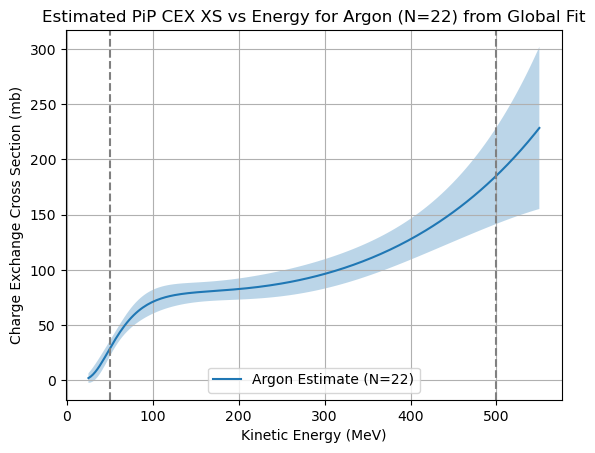

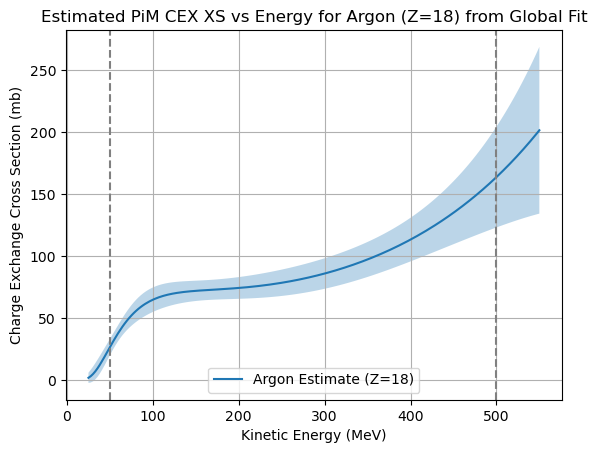

In [167]:
plt.figure()
plt.plot(energy_fit, Estimated_xs_values, label='Argon Estimate (N=22)')
plt.fill_between(energy_fit, 
                 Estimated_xs_values - Estimated_xs_errors,
                 Estimated_xs_values + Estimated_xs_errors,
                 alpha=0.3)
#Vertical lines at min and max data energies
plt.axvline(min(T_all), color='gray', linestyle='--')
plt.axvline(max(T_all), color='gray', linestyle='--')
plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Charge Exchange Cross Section (mb)')
plt.title('Estimated PiP CEX XS vs Energy for Argon (N=22) from Global Fit')
plt.legend()
plt.grid(True)
plt.savefig('estimated_pip_cex_xs_argon_2D_fit.png')
plt.show()

plt.figure()
plt.plot(energy_fit, Estimated_xs_values_PiM, label='Argon Estimate (Z=18)')
plt.fill_between(energy_fit, 
                 Estimated_xs_values_PiM - Estimated_xs_errors_PiM,
                 Estimated_xs_values_PiM + Estimated_xs_errors_PiM,
                 alpha=0.3)
#Vertical lines at min and max data energies
plt.axvline(min(T_all), color='gray', linestyle='--')
plt.axvline(max(T_all), color='gray', linestyle='--')
plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Charge Exchange Cross Section (mb)')
plt.title('Estimated PiM CEX XS vs Energy for Argon (Z=18) from Global Fit')
plt.legend()
plt.grid(True)
plt.savefig('estimated_pim_cex_xs_argon_2D_fit.png')
plt.show()

In [168]:
#Plot the interpolated XS vs the global fit XS at many energy values for argon
#Have both error bands shown

energy_fit = np.linspace(0, 550, 200)
Estimated_xs_values_interp = []
Estimated_xs_errors_interp = []
Estimated_xs_values_global = []
Estimated_xs_errors_global = []
for E in energy_fit:
    #Interpolation method
    est_log_xs, est_log_xs_err = estimate_log_xs_interpolated(N_argon, E)
    est_xs = np.exp(est_log_xs)
    est_xs_err = est_xs * est_log_xs_err
    Estimated_xs_values_interp.append(est_xs)
    Estimated_xs_errors_interp.append(est_xs_err)
    #Global fit method
    pred = predict_sigma(N_argon, E, theta_hat, Cov, T0=T0, degree=degree, use_interaction=True)
    Estimated_xs_values_global.append(pred["median"])
    factor68 = pred["factor68"]
    xs_err = pred["median"] * (factor68 - 1)  # approximate symmetric error
    Estimated_xs_errors_global.append(xs_err)
Estimated_xs_values_interp = np.array(Estimated_xs_values_interp)
Estimated_xs_errors_interp = np.array(Estimated_xs_errors_interp)
Estimated_xs_values_global = np.array(Estimated_xs_values_global)
Estimated_xs_errors_global = np.array(Estimated_xs_errors_global)


/tmp/ipykernel_5274/3254498310.py:103: RuntimeWarning: divide by zero encountered in log
  estimated_log_xs = np.log(xs_extrapolated)
/tmp/ipykernel_5274/703863172.py:13: RuntimeWarning: divide by zero encountered in log
  t = np.log(T / T0)
/tmp/ipykernel_5274/703863172.py:49: RuntimeWarning: invalid value encountered in matmul
  mu = float(x @ theta_hat)
/tmp/ipykernel_5274/703863172.py:50: RuntimeWarning: invalid value encountered in matmul
  V_mean = float(x @ Cov @ x)


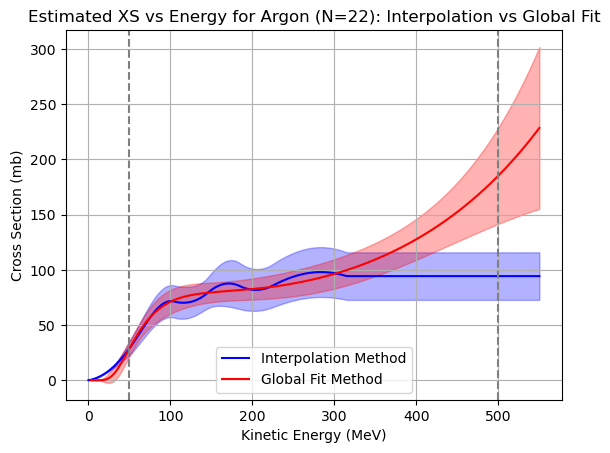

In [169]:
plt.figure()
plt.plot(energy_fit, Estimated_xs_values_interp, label='Interpolation Method', color='blue')
plt.fill_between(energy_fit, 
                 Estimated_xs_values_interp - Estimated_xs_errors_interp,
                 Estimated_xs_values_interp + Estimated_xs_errors_interp,
                 color='blue', alpha=0.3)
plt.plot(energy_fit, Estimated_xs_values_global, label='Global Fit Method', color='red')
plt.fill_between(energy_fit, 
                 Estimated_xs_values_global - Estimated_xs_errors_global,
                 Estimated_xs_values_global + Estimated_xs_errors_global,
                 color='red', alpha=0.3)
#Vertical lines at min and max data energies
plt.axvline(min(T_all), color='gray', linestyle='--')
plt.axvline(max(T_all), color='gray', linestyle='--')
plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Cross Section (mb)')
plt.title('Estimated XS vs Energy for Argon (N=22): Interpolation vs Global Fit')
plt.legend()
plt.grid(True)
plt.show()

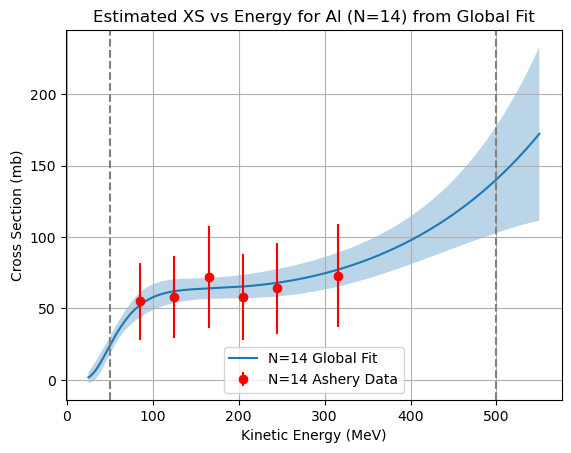

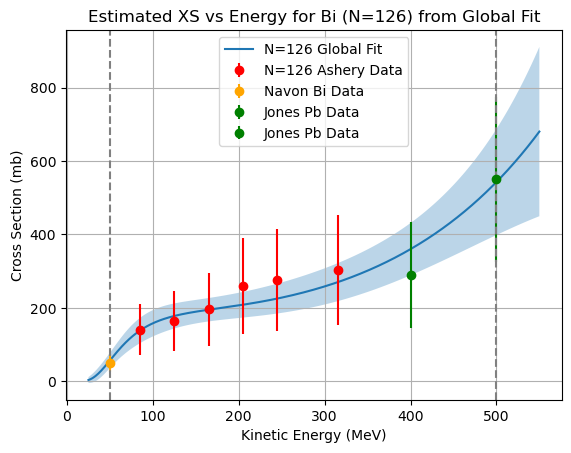

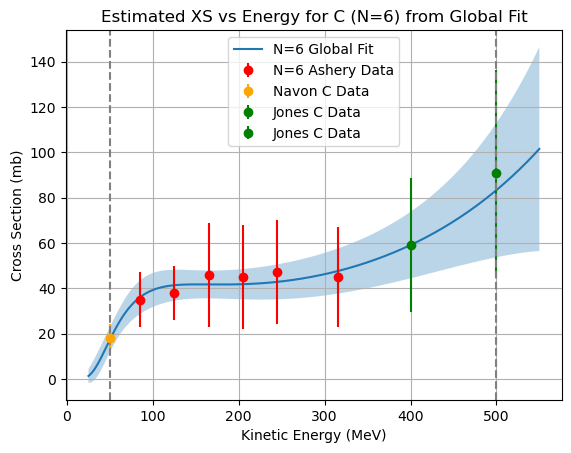

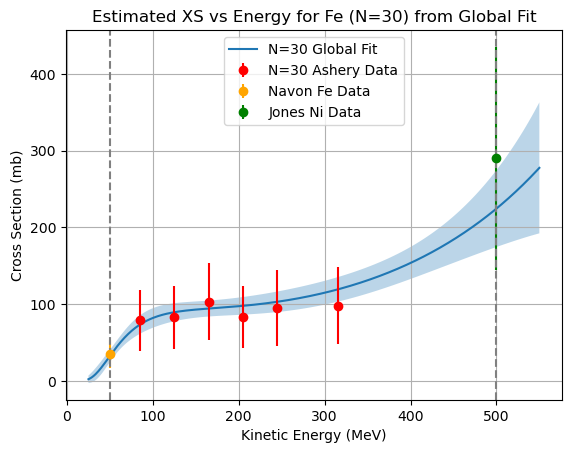

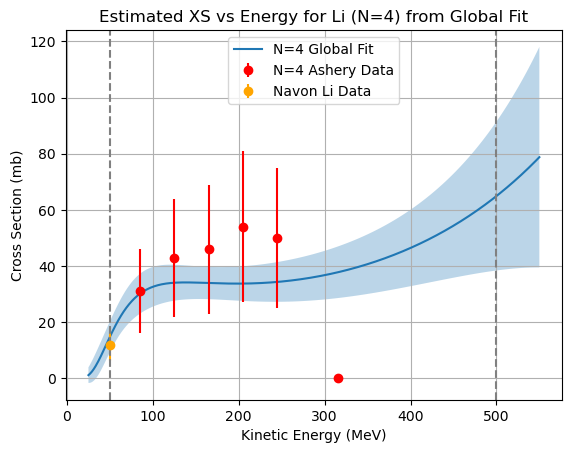

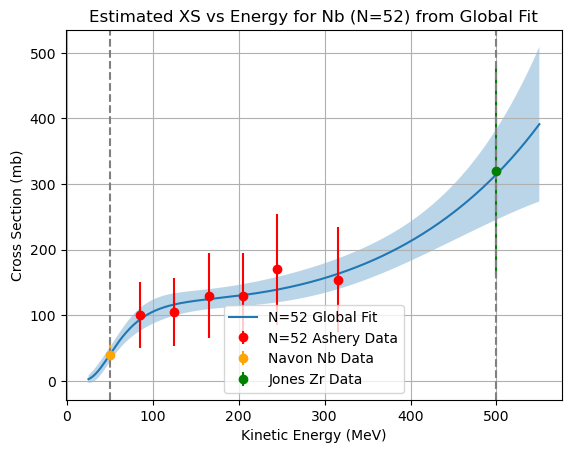

In [170]:
#For this global fit, verify:
#For each nucleus (N value), plot the XS as a function of energy
#Plot the global fit XS with error bands as well as the data points for each energy
N_values_to_plot = [14, 126, 6, 30, 4, 52]  # N values for Al, Bi, C, Fe, Li, Nb
energy_fit = np.linspace(25, 550, 500)
for N in N_values_to_plot:
    Estimated_xs_values = []
    Estimated_xs_errors = []
    for E in energy_fit:
        pred = predict_sigma(N, E, theta_hat, Cov, T0=T0, degree=degree, use_interaction=True)
        Estimated_xs_values.append(pred["median"])
        factor68 = pred["factor68"]
        xs_err = pred["median"] * (factor68 - 1)  # approximate symmetric error
        Estimated_xs_errors.append(xs_err)
    Estimated_xs_values = np.array(Estimated_xs_values)
    Estimated_xs_errors = np.array(Estimated_xs_errors)

    plt.figure()
    plt.plot(energy_fit, Estimated_xs_values, label=f'N={N} Global Fit')
    plt.fill_between(energy_fit, 
                     Estimated_xs_values - Estimated_xs_errors,
                     Estimated_xs_values + Estimated_xs_errors,
                     alpha=0.3)

    #Plot the data points for this N value
    xs_data = []
    xs_data_errors = []
    energy_data = []
    for i, E in enumerate(energies):
        data_nuclei = ["Al", "Bi", "C", "Fe", "Li", "Nb"]
        data_N_list = [nuclei[nuc]["N"] for nuc in data_nuclei]
        if N in data_N_list:
            idx = data_N_list.index(N)
            if idx < len([data_al, data_bi, data_c, data_fe, data_li, data_nb]):
                data = [data_al, data_bi, data_c, data_fe, data_li, data_nb][idx]
                data_idx = np.where(data[:,0] == E)
                if len(data_idx[0]) > 0:
                    xs_data.append(data[data_idx,1][0][0])
                    xs_data_errors.append(data[data_idx,2][0][0])
                    energy_data.append(E)
    plt.errorbar(energy_data, xs_data, yerr=xs_data_errors, fmt='o', label=f'N={N} Ashery Data', color='red')

    #If navon has this nucleus, plot that data point as well
    navon_nuclei = {"Bi": 126, "C": 6, "Fe": 30, "Li": 4, "Nb": 52}
    for nuc, N_navon in navon_nuclei.items():
        if N == N_navon:
            navon_data_idx = np.where(data_navon[:,0] == N)
            if len(navon_data_idx[0]) > 0:
                xs_navon = data_navon[navon_data_idx,1][0][0]
                xs_navon_err = data_navon[navon_data_idx,2][0][0]
                plt.errorbar(50, xs_navon, yerr=xs_navon_err, fmt='o', label=f'Navon {nuc} Data', color='orange')

    #If Jones has this nucleus, plot that data point as well
    jones_nuclei = {
        "C": 6,
        "Ni": 30,
        "Zr": 52,
        "Sn": 70,
        "Pb": 126
    }
    for nuc, N_jones in jones_nuclei.items():
        if N == N_jones:
            data_jones = np.loadtxt(f'pipA_cex/jones-pip-{nuc.lower()}-cex.dat', skiprows=4)
            #If there is only one row, make sure it is 2D
            if data_jones.ndim == 1:
                data_jones = data_jones[np.newaxis, :]
            for E in [400.0, 500.0]:
                idx = np.where(data_jones[:,0] == E)
                if len(idx[0]) > 0:
                    xs = data_jones[idx,1][0][0]
                    xs_err = data_jones[idx,2][0][0]
                    plt.errorbar(E, xs, yerr=xs_err, fmt='o', label=f'Jones {nuc} Data', color='green')

    #plot vertical lines at the minimum and maximum energy values of the data
    #So we can see where we are extrapolating
    plt.axvline(min(T_all), color='gray', linestyle='--')
    plt.axvline(max(T_all), color='gray', linestyle='--')
    plt.xlabel('Kinetic Energy (MeV)')
    plt.ylabel('Cross Section (mb)')
    #Title it with both N value and element symbol
    element_symbol = [key for key, value in nuclei.items() if value["N"] == N][0]
    plt.title(f'Estimated XS vs Energy for {element_symbol} (N={N}) from Global Fit')
    plt.legend()
    plt.grid(True)
    #Save the figure, including both N value and element symbol in the filename
    plt.savefig(f'estimated_cex_xs_KE_2D_fit_{element_symbol}_N{N}.png')
    plt.show()

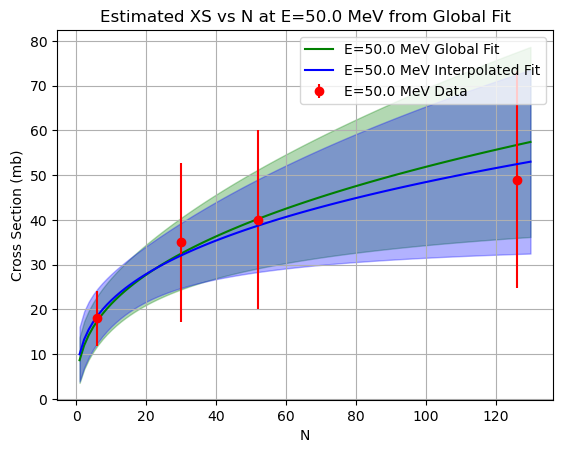

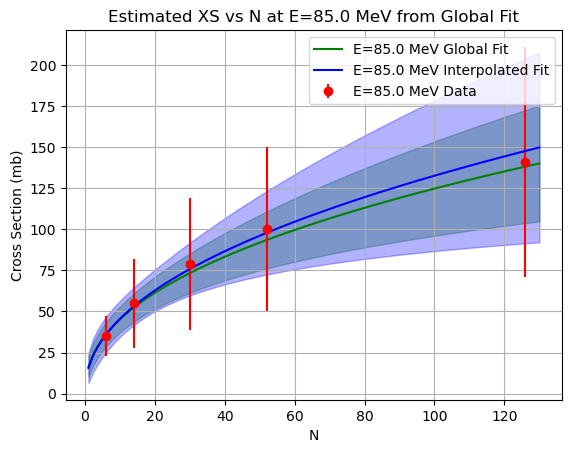

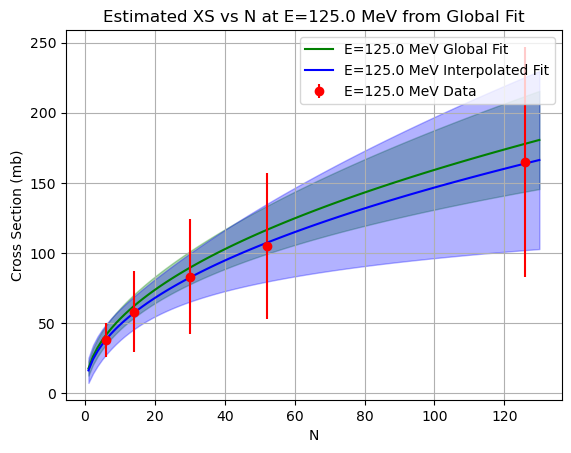

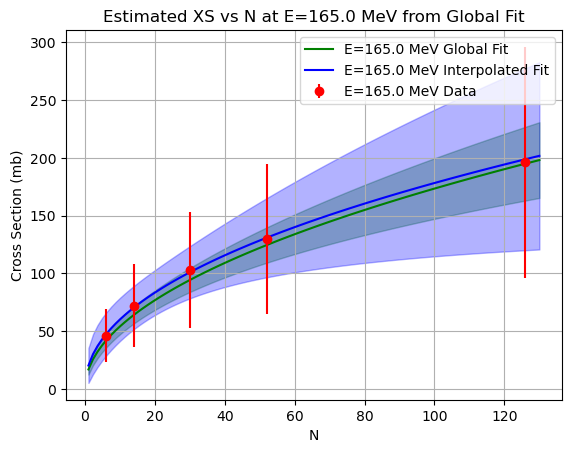

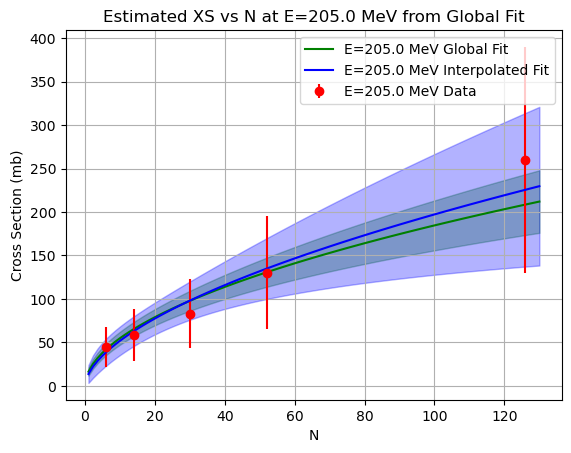

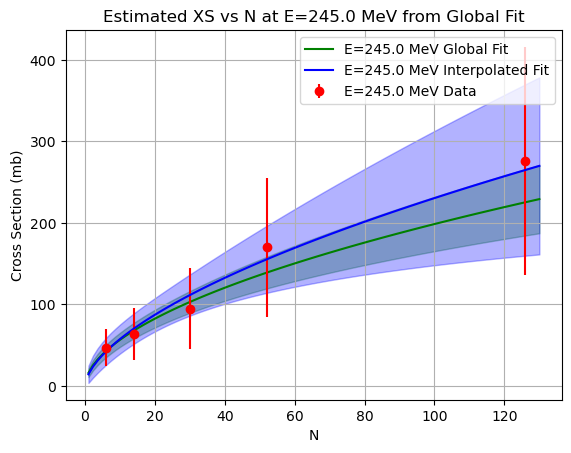

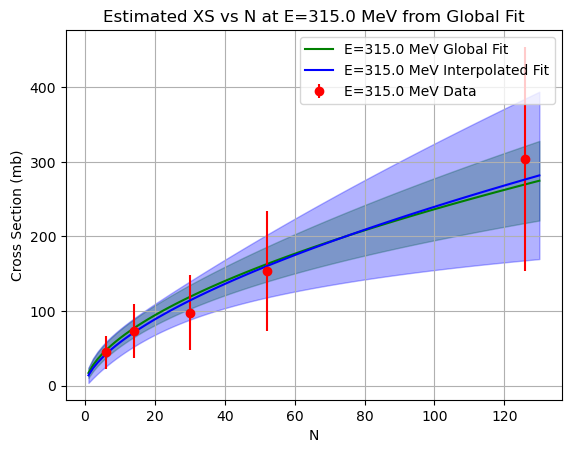

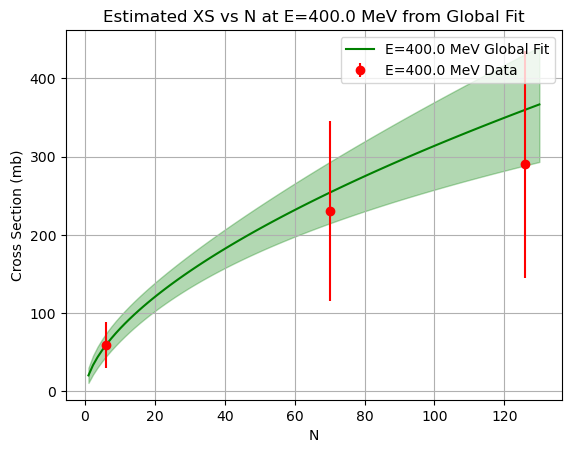

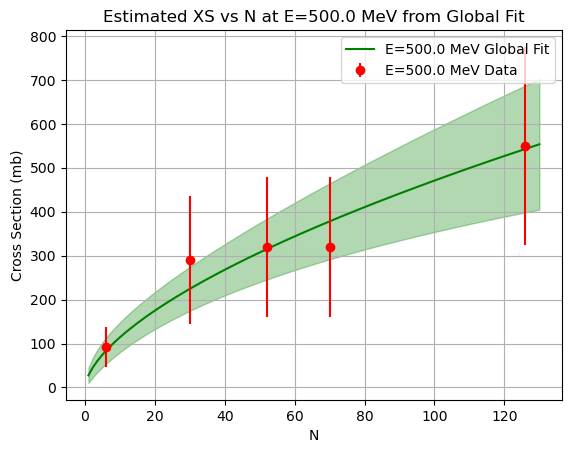

In [171]:
#Then for each KE in the Ashery and Navon data, plot the XS as a function of N
for E in np.unique(T_all):
    Estimated_xs_values = []
    Estimated_xs_errors = []
    N_fit = np.linspace(1, 130, 100)
    for N in N_fit:
        pred = predict_sigma(N, E, theta_hat, Cov, T0=T0, degree=degree, use_interaction=True)
        Estimated_xs_values.append(pred["median"])
        factor68 = pred["factor68"]
        xs_err = pred["median"] * (factor68 - 1)  # approximate symmetric error
        Estimated_xs_errors.append(xs_err)
    Estimated_xs_values = np.array(Estimated_xs_values)
    Estimated_xs_errors = np.array(Estimated_xs_errors)

    plt.figure()
    plt.plot(N_fit, Estimated_xs_values, label=f'E={E} MeV Global Fit',color='green')
    plt.fill_between(N_fit, 
                     Estimated_xs_values - Estimated_xs_errors,
                     Estimated_xs_values + Estimated_xs_errors,color ='green',
                     alpha=0.3)

    #Plot the data points for this energy
    xs_data = []
    xs_data_errors = []
    N_data = []
    for i, N in enumerate(N_all):
        if T_all[i] == E:
            xs_data.append(xs_all[i])
            xs_data_errors.append(xs_err_all[i])
            N_data.append(N)
    plt.errorbar(N_data, xs_data, yerr=xs_data_errors, fmt='o', label=f'E={E} MeV Data', color='red')

    #Also overlay the single-energy fit curves and bands for comparison
    #Only do this if we have a fit for this energy
    if E in energies_extended:
        Estimated_log_xs_values, Estimated_log_xs_errors = estimate_log_xs_interpolated(N_fit, E)
        Estimated_xs_values_single = np.exp(Estimated_log_xs_values)
        Estimated_xs_errors_single = Estimated_xs_values_single * Estimated_log_xs_errors  # Propagate
        plt.plot(N_fit, Estimated_xs_values_single, label=f'E={E} MeV Interpolated Fit', color='blue')
        plt.fill_between(N_fit, 
                         Estimated_xs_values_single - Estimated_xs_errors_single,
                         Estimated_xs_values_single + Estimated_xs_errors_single,
                         color='blue', alpha=0.3)

    plt.xlabel('N')
    plt.ylabel('Cross Section (mb)')
    plt.title(f'Estimated XS vs N at E={E} MeV from Global Fit')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'estimated_cex_xs_N_2D_fit_{element_symbol}_KE{E}.png')
    plt.show()

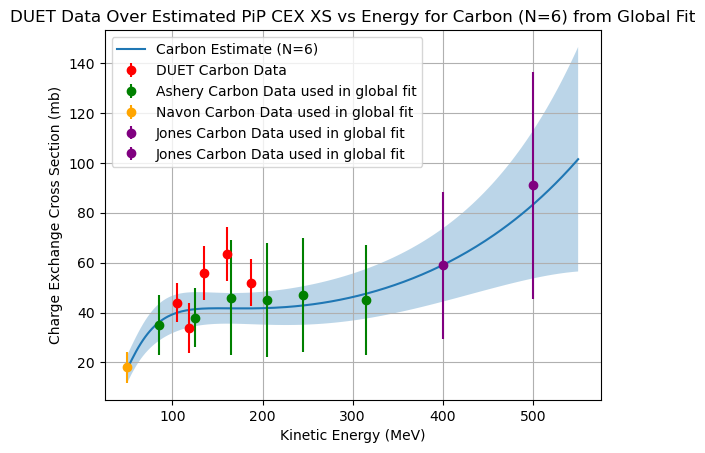

In [174]:
## Test the new fit against additional data:
#DUET, Bowles, 165 MeV Ashery data

#Carbon data from duet experiment:
data_duet_c = np.loadtxt('pipA_cex/duet-pip-c-cex.dat', skiprows=1)
#Data file looks like:
# pi+ Be single charge exchange cross section
# source: DUET, Phys Rev C95, 045203 (table IV)
# 
# p(MeV) CEx(mb) Err(mb)
#201.6       44.0       7.9
#216.6       33.8       10.2
#237.2       55.8       10.8
#265.6       63.5       10.8
#295.1       52.0       9.3

#First convert momentum to kinetic energy
def momentum_to_kinetic_energy(p, m_pion=139.57):
    E_total = np.sqrt(p**2 + m_pion**2)
    KE = E_total - m_pion
    return KE

KE_duet = momentum_to_kinetic_energy(data_duet_c[:,0])
xs_duet = data_duet_c[:,1]
xs_err_duet = data_duet_c[:,2]

#Plot the duet data, along with the global fit estimate for carbon (N=6) at a range of energies
N_carbon = 6
energy_fit = np.linspace(50, 550, 200)
Estimated_xs_values = []
Estimated_xs_errors = []
for E in energy_fit:
    pred = predict_sigma(N_carbon, E, theta_hat, Cov, T0=T0, degree=degree, use_interaction=True)
    Estimated_xs_values.append(pred["median"])
    factor68 = pred["factor68"]
    xs_err = pred["median"] * (factor68 - 1)  # approximate symmetric error
    Estimated_xs_errors.append(xs_err)
Estimated_xs_values = np.array(Estimated_xs_values)
Estimated_xs_errors = np.array(Estimated_xs_errors)

plt.figure()
plt.plot(energy_fit, Estimated_xs_values, label='Carbon Estimate (N=6)')
plt.fill_between(energy_fit, 
                 Estimated_xs_values - Estimated_xs_errors,
                 Estimated_xs_values + Estimated_xs_errors,
                 alpha=0.3)
plt.errorbar(KE_duet, xs_duet, yerr=xs_err_duet, fmt='o', label='DUET Carbon Data', color='red')

#Also plot existing Ashery Carbon data points for reference
energies_c = data_c[:,0]
xs_c = data_c[:,1]
xs_err_c = data_c[:,2]
plt.errorbar(energies_c, xs_c, yerr=xs_err_c, fmt='o', label='Ashery Carbon Data used in global fit', color='green')

#And plot existing Navon Carbon data point at 50 MeV
idx_navon_c = np.where(data_navon[:,0] == N_carbon)
if len(idx_navon_c[0]) > 0:
    xs_navon_c = data_navon[idx_navon_c,1][0][0]
    xs_navon_err_c = data_navon[idx_navon_c,2][0][0]
    plt.errorbar(50.0, xs_navon_c, yerr=xs_navon_err_c, fmt='o', label='Navon Carbon Data used in global fit', color='orange')

# And plot Jones Carbon data at 400 and 500 MeV
data_jones_c = np.loadtxt('pipA_cex/jones-pip-c-cex.dat', skiprows=4)
#If there is only one row, make sure it is 2D
if data_jones_c.ndim == 1:
    data_jones_c = data_jones_c[np.newaxis, :]
for E in [400.0, 500.0]:
    idx = np.where(data_jones_c[:,0] == E)
    if len(idx[0]) > 0:
        xs = data_jones_c[idx,1][0][0]
        xs_err = data_jones_c[idx,2][0][0]
        plt.errorbar(E, xs, yerr=xs_err, fmt='o', label=f'Jones Carbon Data used in global fit', color='purple')

plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Charge Exchange Cross Section (mb)')
plt.title('DUET Data Over Estimated PiP CEX XS vs Energy for Carbon (N=6) from Global Fit')
plt.legend()
plt.grid(True)
plt.savefig('estimated_pip_cex_xs_carbon_duet_2D_fit.png')
plt.show()



('pi+', '12C', 64, 10)
('pi+', '16O', 80, 12)
('pi+', 'Ni', 158, 20)
('pi+', 'Pb', 252, 30)
('pi-', '12C', 64, 10)
('pi-', '16O', 80, 12)
('pi-', '18O', 73, 15)
('pi-', '129Sn', 127, 25)
('pi-', 'Pb', 113, 16)
Probes: ['pi+' 'pi+' 'pi+' 'pi+' 'pi-' 'pi-' 'pi-' 'pi-' 'pi-']
Targets: ['12C' '16O' 'Ni' 'Pb' '12C' '16O' '18O' '129Sn' 'Pb']
XS values: [ 64  80 158 252  64  80  73 127 113]
Errors: [10 12 20 30 10 12 15 25 16]


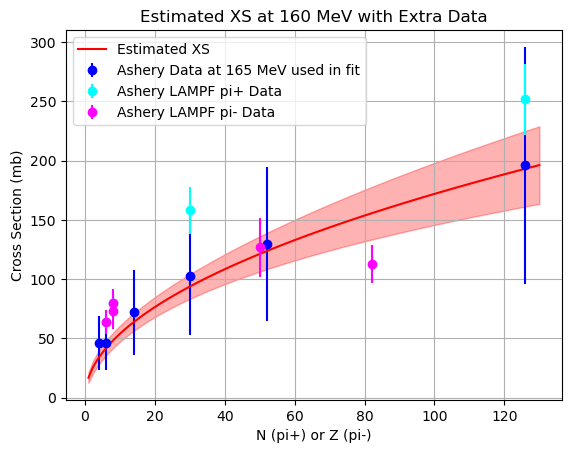

In [175]:
#Recreate the estimated XS plot for 165 MeV, including additional data from "ashery-pip-pim-A-cex_clean.dat"
#First read in the data from the file appropriately
# The data file is the following:
#Ashery (LAMPF) 160 MeV
# PRC 30, 946 (1984)
#probe       target       xs (mb)       error (mb)
#pi+       12C       64       10
#pi+       16O       80       12
#pi+       Ni       158       20
#pi+       Pb       252       30
#pi-       12C       64       10
#pi-       16O       80       12
#pi-       18O       73       15
#pi-       129Sn       127       25
#pi-       Pb       113       16

#There are exactly 7 spaces bewteen each column
data_cex_extra = np.genfromtxt('pipA_cex/ashery-pip-pim-A-cex_clean.dat', skip_header=3, dtype=None, encoding=None,
                              names=['probe', 'target', 'xs', 'error'], delimiter='       ')

#Print out rows and check they are read in correctly
for row in data_cex_extra:
    print(row)

#Print out each column separately to verify
print("Probes:", data_cex_extra['probe'])
print("Targets:", data_cex_extra['target'])
print("XS values:", data_cex_extra['xs'])
print("Errors:", data_cex_extra['error'])

#Map target nuclei to N values
target_to_N = {
    "12C": 6,
    "16O": 8,
    "Ni": 30,
    "Pb": 126,
    "18O": 10,
    "129Sn": 79,
}

#Map target nuclei to Z values (for pi- data)
target_to_Z = {
    "12C": 6,
    "16O": 8,
    "Ni": 28,
    "Pb": 82,
    "18O": 8,
    "129Sn": 50,
}

#Extract data for 165 MeV pi+ CEX
E_target = 160
xs_values_extra = []
xs_errors_extra = []
N_values_extra = []
for row in data_cex_extra:
    probe = row['probe']
    target = row['target']
    xs = row['xs']
    xs_err = row['error']
    if probe == 'pi+' or probe == 'pi+/-':
        N = target_to_N[target]
        xs_values_extra.append(xs)
        xs_errors_extra.append(xs_err)
        N_values_extra.append(N)

#Extract data for 165 MeV pi- CEX
xs_values_extra_pim = []
xs_errors_extra_pim = []
Z_values_extra_pim = []
for row in data_cex_extra:
    probe = row['probe']
    target = row['target']
    xs = row['xs']
    xs_err = row['error']
    if probe == 'pi-' or probe == 'pi+/-':
        Z = target_to_Z[target]
        xs_values_extra_pim.append(xs)
        xs_errors_extra_pim.append(xs_err)
        Z_values_extra_pim.append(Z)

#Now plot the estimated XS at 160 MeV along with the extra data points
plt.figure()

#Plot the estimated XS curve based on the global fit
N_fit = np.linspace(1, 130, 100)
Estimated_xs_values = []
Estimated_xs_errors = []
for N in N_fit:
    pred = predict_sigma(N, E_target, theta_hat, Cov, T0=T0, degree=degree, use_interaction=True)
    Estimated_xs_values.append(pred["median"])
    factor68 = pred["factor68"]
    xs_err = pred["median"] * (factor68 - 1)  # approximate symmetric error
    Estimated_xs_errors.append(xs_err)
Estimated_xs_values = np.array(Estimated_xs_values)
Estimated_xs_errors = np.array(Estimated_xs_errors)

#Plot the previous data at 165 MeV as well
xs_values_165 = []
xs_errors_165 = []
N_values_165 = []
for nuc, data in zip(nuclei_list, [data_al, data_bi, data_c, data_fe, data_li, data_nb]):
    idx = np.where(data[:,0] == 165)
    if len(idx[0]) > 0:
        xs = data[idx,1][0][0]
        xs_err = data[idx,2][0][0]
        xs_values_165.append(xs)
        xs_errors_165.append(xs_err)
        N = nuclei[nuc]["N"]
        N_values_165.append(N)
plt.errorbar(N_values_165, xs_values_165, yerr=xs_errors_165, fmt='o', label='Ashery Data at 165 MeV used in fit', color='blue')

plt.plot(N_fit, Estimated_xs_values, label='Estimated XS', color='red')
plt.fill_between(N_fit, 
                 Estimated_xs_values - Estimated_xs_errors,
                 Estimated_xs_values + Estimated_xs_errors,
                 color='red', alpha=0.3)

#Plot the extra data points
plt.errorbar(N_values_extra, xs_values_extra, yerr=xs_errors_extra, fmt='o', label='Ashery LAMPF pi+ Data', color='cyan')
plt.errorbar(Z_values_extra_pim, xs_values_extra_pim, yerr=xs_errors_extra_pim, fmt='o', label='Ashery LAMPF pi- Data', color='magenta')

#Also add in estimate for argon with error
Argon_xs_log, Argon_xs_log_err = estimate_log_xs(22, 165)
Argon_xs = np.exp(Argon_xs_log)
Argon_xs_err = Argon_xs * Argon_xs_log_err
#plt.errorbar(22, Argon_xs, yerr=Argon_xs_err, fmt='o', label='pi+ Argon Estimate', color='green')

plt.xlabel('N (pi+) or Z (pi-)')
plt.ylabel('Cross Section (mb)')
plt.title('Estimated XS at 160 MeV with Extra Data')
plt.legend()
plt.grid(True)
plt.savefig('estimated_cex_xs_N_165MeV_extra_data.png')
plt.show()

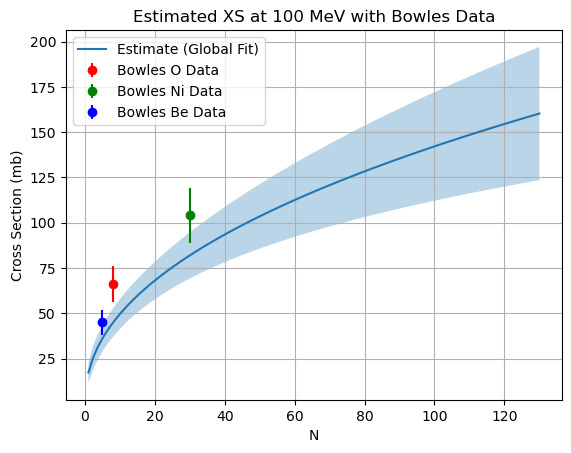

In [176]:
#Now look at Bowles data, all at 100 MeV, in separate files for O, Ni, and Be
data_bowles_o = np.loadtxt('pipA_cex/bowles-pip-o-cex.dat', skiprows=4)
data_bowles_ni = np.loadtxt('pipA_cex/bowles-pip-ni-cex.dat', skiprows=3)
data_bowles_be = np.loadtxt('pipA_cex/bowles-pip-be-cex.dat', skiprows=3)

#These data contain 1 row, so cast to 2D arrays for consistency
data_bowles_o = data_bowles_o.reshape((1, -1))
data_bowles_ni = data_bowles_ni.reshape((1, -1))
data_bowles_be = data_bowles_be.reshape((1, -1))    

#Data files look like:
# pi+ O single charge exchange cross section
# source: Bowles et al., Phys Rev C 24, 486 (1981  table II)
# Data point
# KE(MeV) CEx(mb) Err(mb)
#100       66.0       10.0

#Now plot the Bowles data along with the global fit estimate for a range of nuclei at 100 MeV
plt.figure()
N_fit = np.linspace(1, 130, 100)
Estimated_xs_values = []
Estimated_xs_errors = []
for N in N_fit:
    pred = predict_sigma(N, 100.0, theta_hat, Cov, T0=T0, degree=degree, use_interaction=True)
    Estimated_xs_values.append(pred["median"])
    factor68 = pred["factor68"]
    xs_err = pred["median"] * (factor68 - 1)  # approximate symmetric error
    Estimated_xs_errors.append(xs_err)
Estimated_xs_values = np.array(Estimated_xs_values)
Estimated_xs_errors = np.array(Estimated_xs_errors)

plt.plot(N_fit, Estimated_xs_values, label='Estimate (Global Fit)')
plt.fill_between(N_fit, 
                 Estimated_xs_values - Estimated_xs_errors,
                 Estimated_xs_values + Estimated_xs_errors,
                 alpha=0.3)

#Plot Bowles Oxygen data point (N=8)
xs_o = data_bowles_o[0,1]
xs_o_err = data_bowles_o[0,2]
plt.errorbar(8, xs_o, yerr=xs_o_err, fmt='o', label='Bowles O Data', color='red')
#Plot Bowles Nickel data point (N=30)
xs_ni = data_bowles_ni[0,1]
xs_ni_err = data_bowles_ni[0,2]
plt.errorbar(30, xs_ni, yerr=xs_ni_err, fmt='o', label='Bowles Ni Data', color='green')
#Plot Bowles Beryllium data point (N=5)
xs_be = data_bowles_be[0,1]
xs_be_err = data_bowles_be[0,2]
plt.errorbar(5, xs_be, yerr=xs_be_err, fmt='o', label='Bowles Be Data', color='blue')

plt.xlabel('N')
plt.ylabel('Cross Section (mb)')
plt.title('Estimated XS at 100 MeV with Bowles Data')
plt.legend()
plt.grid(True)
plt.savefig('estimated_cex_xs_N_100MeV_bowles_data.png')
plt.show()
